In [1]:
%load_ext dotenv
%dotenv

import tqdm
from flax import linen as nn
import jax
from typing import Dict, Callable, Sequence, Any, Union
from dataclasses import field
import jax.numpy as jnp
import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
import optax
from flax import struct                # Flax dataclasses
import time
import os
from datetime import datetime
from flax.training import orbax_utils
import functools

2024-07-09 02:53:49.640909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Initialization

In [2]:
# Some Optimizations
import ctypes

_libcudart = ctypes.CDLL("libcudart.so")
# Set device limit on the current device
# cudaLimitMaxL2FetchGranularity = 0x05
pValue = ctypes.cast((ctypes.c_int * 1)(), ctypes.POINTER(ctypes.c_int))
_libcudart.cudaDeviceSetLimit(ctypes.c_int(0x05), ctypes.c_int(128))
_libcudart.cudaDeviceGetLimit(pValue, ctypes.c_int(0x05))
assert pValue.contents.value == 128

In [3]:
normalizeImage = lambda x: jax.nn.standardize(x, mean=[127.5], std=[127.5])
denormalizeImage = lambda x: (x + 1.0) * 127.5


def plotImages(imgs, fig_size=(8, 8), dpi=100):
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    imglen = imgs.shape[0]
    for i in range(imglen):
        plt.subplot(fig_size[0], fig_size[1], i + 1)
        plt.imshow(tf.cast(denormalizeImage(imgs[i, :, :, :]), tf.uint8))
        plt.axis("off")
    plt.show()

class RandomClass():
    def __init__(self, rng: jax.random.PRNGKey):
        self.rng = rng

    def get_random_key(self):
        self.rng, subkey = jax.random.split(self.rng)
        return subkey
    
    def get_sigmas(self, steps):
        return jnp.tan(self.theta_min + steps * (self.theta_max - self.theta_min)) / self.kappa

    def reset_random_key(self):
        self.rng = jax.random.PRNGKey(42)

class MarkovState(struct.PyTreeNode):
    pass

class RandomMarkovState(MarkovState):
    rng: jax.random.PRNGKey

    def get_random_key(self):
        rng, subkey = jax.random.split(self.rng)
        return RandomMarkovState(rng), subkey

# Data Pipeline

In [4]:
def get_dataset(data_name="celeb_a", batch_size=64, image_scale=256):
    def augmenter(image_scale=256, method="area"):
        @tf.function()
        def augment(sample):
            image = (
                tf.cast(sample["image"], tf.float32) - 127.5
            ) / 127.5
            image = tf.image.resize(
                image, [image_scale, image_scale], method=method, antialias=True
            )
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_contrast(image, 0.999, 1.05)
            image = tf.image.random_brightness(image, 0.2)

            image = tf.clip_by_value(image, -1.0, 1.0)
            return image
        return augment

    # Load CelebA Dataset
    data: tf.data.Dataset = tfds.load(data_name, split="all", shuffle_files=True)
    final_data = (
        data
        .cache()  # Cache after augmenting to avoid recomputation
        # .prefetch(tf.data.experimental.AUTOTUNE)
        # .batch(128, num_parallel_calls=tf.data.AUTOTUNE)
        .map(
            augmenter(image_scale, method="area"),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        .repeat()  # Repeats the dataset indefinitely
        # .unbatch()
        .shuffle(4096)  # Ensure this is adequate for your dataset size
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE)
    ).as_numpy_iterator()
    return final_data, len(data)


# Noise Samplers

In [5]:
from flaxdiff.schedulers import CosineNoiseSchedule, NoiseScheduler, GeneralizedNoiseScheduler, KarrasVENoiseScheduler, EDMNoiseScheduler
from flaxdiff.predictors import VPredictionTransform, EpsilonPredictionTransform, DiffusionPredictionTransform, DirectPredictionTransform, KarrasPredictionTransform

## Testing Schedulers

In [ ]:
data, _ = get_dataset("oxford_flowers102", batch_size=64, image_scale=64)
images = next(iter(data))

In [ ]:
schedule = KarrasVENoiseScheduler(1000)
ts, rand = schedule.generate_timesteps(100, RandomMarkovState(jax.random.PRNGKey(42)))
print(ts)
sigmas = schedule.get_sigmas(ts)
# # print(sigmas)
plt.scatter(ts, sigmas)
plt.show()
noise = jax.random.normal(jax.random.PRNGKey(4), (1, 64, 64, 3))
# data = jax.random.normal(jax.random.PRNGKey(5), (1, 64, 64, 3))
data = images[0]
ts = 999
sigma = schedule.get_sigmas(ts)
signal_rate, noise_rate = schedule.get_rates(ts)
predictor = KarrasPredictionTransform(1)
x_t, c_in, target = predictor.forward_diffusion(data, noise, ts, schedule)
print(f"x_t at t = {ts}, sigma = {sigma} ==>")
plt.hist(x_t.flatten(), bins=100)
plt.show()
print(jnp.mean(x_t), jnp.std(x_t))
print("c_in", c_in)
model_in = c_in * x_t
print("model_in ==>")
plt.hist(model_in.flatten(), bins=100)
plt.show()

pred = data
print("pred ==>")
plt.hist(pred.flatten(), bins=100)
plt.show()
model_out = predictor.pred_transform(x_t, pred, (signal_rate, noise_rate))
model_pred_x0, model_pred_eps = predictor.backward_diffusion(x_t, model_out, (signal_rate, noise_rate))
print("model_out ==>")
plt.hist(model_out.flatten(), bins=100)
plt.show()
print("model_pred_x0 ==>")
plt.hist(model_pred_x0.flatten(), bins=100)
plt.show()
print("data ==>")
plt.hist(data.flatten(), bins=100)
plt.show()
print("model_pred_noise ==>")
plt.hist(model_pred_eps.flatten(), bins=100)
plt.show()
print("noise ==>")
plt.hist(noise.flatten(), bins=100)
plt.show()
# loss = (model_out - data) ** 2
# plt.hist(loss.flatten(), bins=100)
# plt.show()

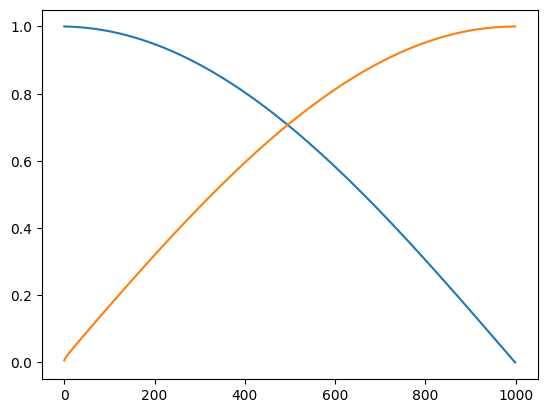

[[[[1.]]]]
at t=0 (Array([[[[0.9999793]]]], dtype=float32), Array([[[[0.00642698]]]], dtype=float32)) at t=1 (Array([[[[0.99995625]]]], dtype=float32), Array([[[[0.00935094]]]], dtype=float32))


In [3]:
# schedule = SimpleNoiseScheduler(1000)
schedule = CosineNoiseSchedule(1000)
plt.plot([schedule.get_rates(i, shape=()) for i in jnp.linspace(0, 1000, 1000)])
# plt.plot([schedule.get_weights(i, shape=()) for i in jnp.linspace(0, 1000, 1000)])
plt.show()
print(schedule.get_max_variance())
get_variance = lambda rates: rates[0] ** 2 + rates[1] ** 2
# plt.plot([get_variance(schedule.get_rates(i, shape=())) for i in jnp.linspace(0, 1000, 1000)])
print("at t=0", schedule.get_rates(0), "at t=1", schedule.get_rates(1))


In [4]:
schedule.get_rates(1000, shape=())

(Array(4.9282517e-05, dtype=float32), Array(1., dtype=float32))

In [29]:
import numpy as np

def cosine_beta_schedule(timesteps, start_angle=0.008, end_angle=0.999):
    ts = np.linspace(0, 1, timesteps + 1, dtype=np.float64)
    alphas_bar = np.cos((ts + start_angle) / (1 + start_angle) * np.pi /2) ** 2
    alphas_bar = alphas_bar/alphas_bar[0]
    betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
    return np.clip(betas, 0, end_angle)


In [11]:
class TimeEmbedding(nn.Module):
    features:int
    max_positions:int=10000

    def setup(self):
        # self.embeddings = nn.Embed(
        #     num_embeddings=max_timesteps, features=out_features
        # )
        half_dim = self.features // 2
        # emb = jnp.log(self.max_positions) / (half_dim - 1)
        # emb = jnp.exp(-emb * jnp.arange(half_dim, dtype=jnp.float32))
        emb = jnp.arange(half_dim, dtype=jnp.float32) / (half_dim - 1)
        emb = (1 / self.max_positions) ** emb
        self.embeddings = emb

    def __call__(self, x):
        x = jax.lax.convert_element_type(x, jnp.float32)
        emb = x[:, None] * self.embeddings[None, :]
        emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=-1)
        return emb
    
class FourierEmbedding(nn.Module):
    features:int
    scale:int = 16

    def setup(self):
        self.freqs = jax.random.normal(jax.random.PRNGKey(42), (self.features // 2, ), dtype=jnp.float32) * self.scale

    def __call__(self, x):
        x = jax.lax.convert_element_type(x, jnp.float32)
        emb = x[:, None] * (2 * jnp.pi * self.freqs)[None, :]
        emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=-1)
        return emb

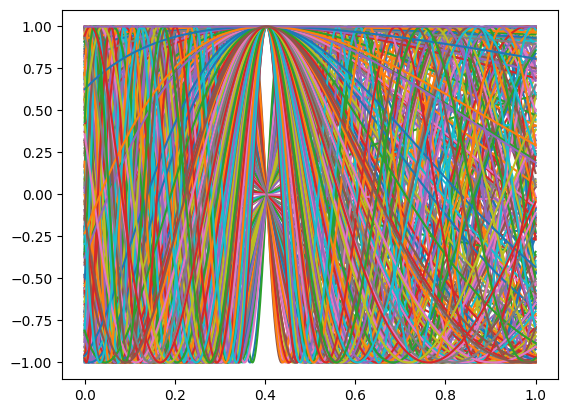

In [36]:
schedule = KarrasVENoiseScheduler(1, sigma_max=80, rho=7)
steps = jnp.linspace(0, 1, 1000)
sigmas = schedule.get_sigmas(steps)
# plt.plot(steps, sigmas)
_, nin = schedule.transform_inputs(jax.random.normal(jax.random.PRNGKey(42), (1, 64, 64, 3)), steps)
# plt.plot(steps, nin)
# temb = TimeEmbedding(features=256)
temb = FourierEmbedding(features=256, scale=1)
param = temb.init(jax.random.PRNGKey(42), nin)
emb = temb.apply(param, nin)
plt.plot(steps, emb)
plt.show()

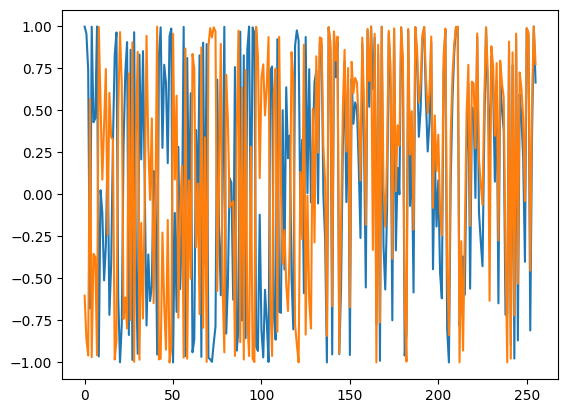

In [37]:
plt.plot(emb[300])
plt.plot(emb[500])

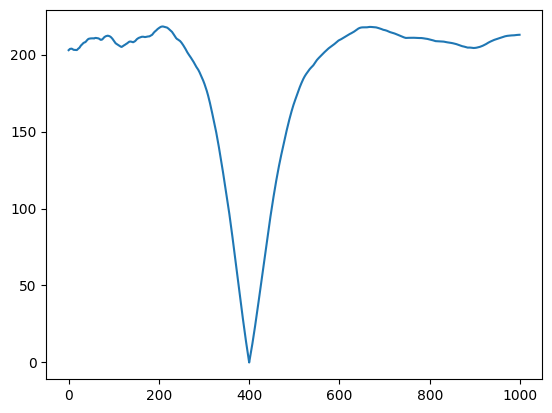

In [38]:
l = [jnp.sum(jnp.abs(emb[400] - i)) for i in emb]
plt.plot(l)

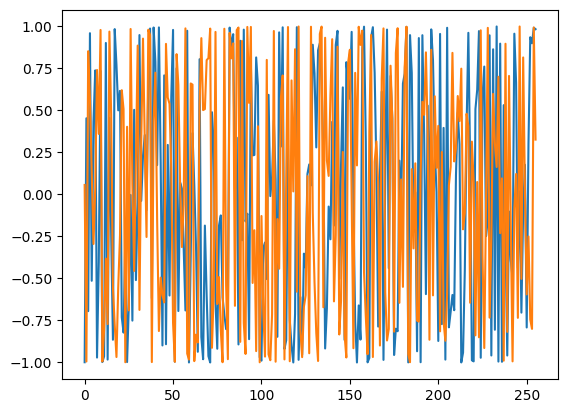

In [ ]:
plt.plot(emb[100])
plt.plot(emb[200])

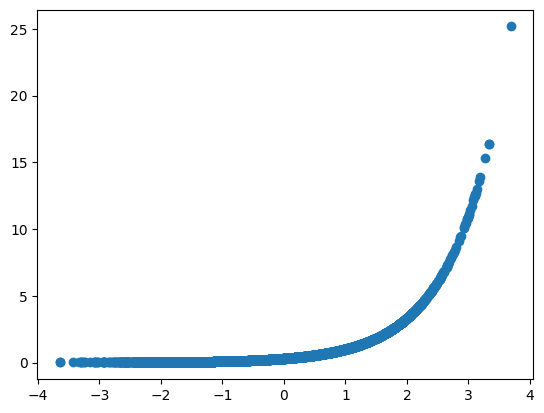

In [ ]:
steps, _ = schedule.generate_timesteps(10000, RandomMarkovState(jax.random.PRNGKey(42)))
sigmas = schedule.get_sigmas(steps)
plt.scatter(steps, sigmas)

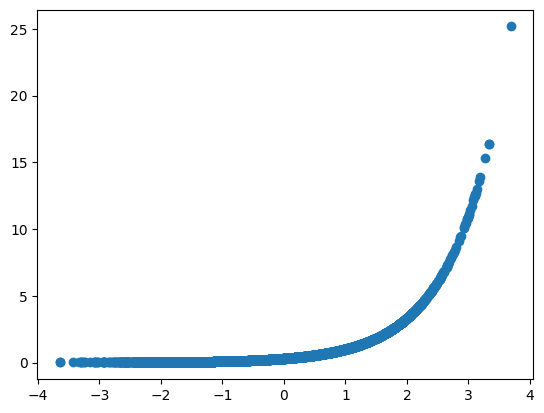

In [ ]:
steps, _ = schedule.generate_timesteps(10000, RandomMarkovState(jax.random.PRNGKey(42)))
sigmas = schedule.get_sigmas(steps)
plt.scatter(steps, sigmas)

### Data Diffusion Testing

In [ ]:
# Visualize adding some noise to some sample images and then removing it
state = RandomMarkovState(jax.random.PRNGKey(4))
# data, _ = get_dataset("oxford_flowers102", batch_size=64, image_scale=64)
images = next(iter(data))
plotImages(images)
noise_level = 0.5# * jnp.ones((images.shape[0], ), dtype=jnp.int32)
noise_level_max = 1
schedule = KarrasVENoiseScheduler(noise_level_max, rho=40, sigma_max=100)
state, rng = state.get_random_key()
signal_rate, noise_rate = schedule.get_rates(noise_level)
print("Rates", signal_rate, noise_rate)
noise = jax.random.normal(rng, shape=images.shape, dtype=jnp.float64)
# noisy_images = images * signal_rate + noise * noise_rate
noisy_images = schedule.add_noise(images, noise, noise_level)
plotImages(noisy_images)
plotImages(noise)
reconstructed_images = schedule.remove_all_noise(noisy_images, noise, noise_level)
plotImages(reconstructed_images)


# Modeling

## Metrics

## Callbacks

## Model Generator

In [6]:
from flaxdiff.models.simple_unet import l2norm, ConvLayer, TimeEmbedding, TimeProjection, Upsample, Downsample, ResidualBlock, PixelShuffle
from flaxdiff.models.simple_unet import FourierEmbedding

from flaxdiff.models.attention import kernel_init

# Kernel initializer to use
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return nn.initializers.variance_scaling(scale=scale, mode="fan_avg", distribution="truncated_normal")

class NormalAttention(nn.Module):
    """
    Simple implementation of the normal attention.
    """
    query_dim: int
    heads: int = 4
    dim_head: int = 64
    dtype: Any = jnp.float32
    precision: Any = jax.lax.Precision.HIGHEST
    use_bias: bool = True
    kernel_init: Callable = lambda : kernel_init(1.0)

    def setup(self):
        inner_dim = self.dim_head * self.heads
        dense = functools.partial(
            nn.DenseGeneral,
            features=[self.heads, self.dim_head], 
            axis=-1, 
            precision=self.precision, 
            use_bias=self.use_bias, 
            kernel_init=self.kernel_init(), 
            dtype=self.dtype
        )
        self.query = dense(name="to_q")
        self.key = dense(name="to_k")
        self.value = dense(name="to_v")

        self.proj_attn = nn.DenseGeneral(
            self.query_dim, 
            axis=(-2, -1), 
            precision=self.precision, 
            use_bias=self.use_bias, 
            dtype=self.dtype, 
            name="to_out_0",
            kernel_init=self.kernel_init()
            # kernel_init=jax.nn.initializers.xavier_uniform()
        )

    @nn.compact
    def __call__(self, x, context=None):
        # x has shape [B, H, W, C]
        context = x if context is None else context
        query = self.query(x)
        key = self.key(context)
        value = self.value(context)

        hidden_states = nn.dot_product_attention(
            query, key, value, dtype=self.dtype, broadcast_dropout=False, dropout_rng=None, precision=self.precision
        )
        proj = self.proj_attn(hidden_states)
        return proj

class AttentionBlock(nn.Module):
    heads: int = 4
    dim_head: int = 32
    use_linear_attention: bool = True
    dtype: Any = jnp.float32
    precision: Any = jax.lax.Precision.HIGH
    use_projection: bool = False

    @nn.compact
    def __call__(self, x):
        inner_dim = self.heads * self.dim_head
        B, H, W, C = x.shape
        normed_x = nn.RMSNorm(epsilon=1e-5, dtype=self.dtype)(x)
        # normed_x = nn.LayerNorm(epsilon=1e-5, dtype=self.dtype)(x)
        if self.use_projection == True:
            if self.use_linear_attention:
                projected_x = nn.Dense(features=inner_dim, 
                                       use_bias=False, precision=self.precision, 
                                       kernel_init=kernel_init(1.0),
                                       dtype=self.dtype, name=f'project_in')(normed_x)
            else:
                projected_x = nn.Conv(
                    features=inner_dim, kernel_size=(1, 1),
                    kernel_init=kernel_init(1.0),
                    strides=(1, 1), padding='VALID', use_bias=False, dtype=self.dtype,
                    precision=self.precision, name=f'project_in_conv',
                )(normed_x)
        else:
            projected_x = normed_x
            inner_dim = C

        projected_x = NormalAttention(
            query_dim=inner_dim,
            heads=self.heads,
            dim_head=self.dim_head,
            name=f'Attention',
            precision=self.precision,
            use_bias=False,
        )(projected_x)

        # projected_x = nn.MultiHeadAttention(num_heads=self.heads, use_bias=False, precision='high', decode=False)(projected_x)

        # projected_x = BasicTransformerBlock(
        #     query_dim=inner_dim,
        #     heads=self.heads,
        #     dim_head=self.dim_head,
        #     name=f'Attention',
        #     precision=self.precision,
        # )(projected_x, projected_x)

        if self.use_projection == True:
            if self.use_linear_attention:
                projected_x = nn.Dense(features=C, precision=self.precision, 
                                       dtype=self.dtype, use_bias=False, 
                                       kernel_init=kernel_init(1.0),
                                       name=f'project_out')(projected_x)
            else:
                projected_x = nn.Conv(
                    features=C, kernel_size=(1, 1),
                    kernel_init=kernel_init(1.0),
                    strides=(1, 1), padding='VALID', use_bias=False, dtype=self.dtype,
                    precision=self.precision, name=f'project_out_conv',
                )(projected_x)

        out = x + projected_x
        return out


## Attention and other prototyping

In [8]:
x = jnp.ones((8, 16, 16, 64))
# context = jnp.ones((8, 16, 16, 64))
attention_block = AttentionBlock(heads=4, dim_head=64//4)
params = attention_block.init(jax.random.PRNGKey(0), x)
out = attention_block.apply(params, x)
print("Output :", out.shape)
print(attention_block.tabulate(jax.random.key(0), x, console_kwargs={"width": 200, "force_jupyter":True, }))
print(jnp.mean(out), jnp.std(out))
# plt.hist(out.flatten(), bins=100)
# %timeit attention_block.apply(params, x)

Output : (8, 16, 16, 64)


                                              AttentionBlock Summary                                               
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path               ┃ module          ┃ inputs                ┃ outputs               ┃ params                   ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                    │ AttentionBlock  │ float32[8,16,16,64]   │ float32[8,16,16,64]   │                          │
├────────────────────┼─────────────────┼───────────────────────┼───────────────────────┼──────────────────────────┤
│ RMSNorm_0          │ RMSNorm         │ float32[8,16,16,64]   │ float32[8,16,16,64]   │ scale: float32[64]       │
│                    │                 │                       │                       │                          │
│                    │                 │                       │                       │ 64 (256 B)               │
├────────────────────┼─────────────────┼───────────────────────┼───────────────────────┼──────────────────────────┤
│ Attention          │ NormalAttention │ float32[8,16,16,64]   │ float32[8,16,16,64]   │                          │
├────────────────────┼─────────────────┼───────────────────────┼───────────────────────┼──────────────────────────┤
│ Attention/to_q     │ DenseGeneral    │ float32[8,16,16,64]   │ float32[8,16,16,4,16] │ kernel: float32[64,4,16] │
│                    │                 │                       │                       │                          │
│                    │                 │                       │                       │ 4,096 (16.4 KB)          │
├────────────────────┼─────────────────┼───────────────────────┼───────────────────────┼──────────────────────────┤
│ Attention/to_k     │ DenseGeneral    │ float32[8,16,16,64]   │ float32[8,16,16,4,16] │ kernel: float32[64,4,16] │
│                    │                 │                       │                       │                          │
│                    │                 │                       │                       │ 4,096 (16.4 KB)          │
├────────────────────┼─────────────────┼───────────────────────┼───────────────────────┼──────────────────────────┤
│ Attention/to_v     │ DenseGeneral    │ float32[8,16,16,64]   │ float32[8,16,16,4,16] │ kernel: float32[64,4,16] │
│                    │                 │                       │                       │                          │
│                    │                 │                       │                       │ 4,096 (16.4 KB)          │
├────────────────────┼─────────────────┼───────────────────────┼───────────────────────┼──────────────────────────┤
│ Attention/to_out_0 │ DenseGeneral    │ float32[8,16,16,4,16] │ float32[8,16,16,64]   │ kernel: float32[4,16,64] │
│                    │                 │                       │                       │                          │
│                    │                 │                       │                       │ 4,096 (16.4 KB)          │
├────────────────────┼─────────────────┼───────────────────────┼───────────────────────┼──────────────────────────┤
│                    │                 │                       │                 Total │ 16,448 (65.8 KB)         │
└────────────────────┴─────────────────┴───────────────────────┴───────────────────────┴──────────────────────────┘
                                                                                                                   
                                        Total Parameters: 16,448 (65.8 KB)                                         




0.79696566 1.2281164


## Main Model

In [7]:

class Unet(nn.Module):
    emb_features:int=64*4,
    feature_depths:list=[64, 128, 256, 512],
    attention_configs:list=[{"heads":8}, {"heads":8}, {"heads":8}, {"heads":8}],
    num_res_blocks:int=2,
    num_middle_res_blocks:int=1,
    activation:Callable = jax.nn.swish
    norm_groups:int=8

    @nn.compact
    def __call__(self, x, temb):
        # print("embedding features", self.emb_features)
        temb = FourierEmbedding(features=self.emb_features)(temb)
        temb = TimeProjection(features=self.emb_features)(temb)
        # print("time embedding", temb.shape)
        feature_depths = self.feature_depths
        attention_configs = self.attention_configs

        conv_type = up_conv_type = down_conv_type = middle_conv_type = "conv"
        # middle_conv_type = "separable"

        x = ConvLayer(
            conv_type,
            features=self.feature_depths[0],
            kernel_size=(3, 3),
            strides=(1, 1),
            kernel_init=kernel_init(1.0)
        )(x)
        downs = [x]

        # Downscaling blocks
        for i, (dim_out, attention_config) in enumerate(zip(feature_depths, attention_configs)):
            dim_in = x.shape[-1]
            # dim_in = dim_out
            for j in range(self.num_res_blocks):
                x = ResidualBlock(
                    down_conv_type,
                    name=f"down_{i}_residual_{j}",
                    features=dim_in,
                    kernel_init=kernel_init(1.0),
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation=self.activation,
                    norm_groups=self.norm_groups
                )(x, temb)
                if attention_config is not None and j == self.num_res_blocks - 1:   # Apply attention only on the last block
                    x = AttentionBlock(heads=attention_config['heads'], 
                                       dim_head=dim_in // attention_config['heads'],
                                       name=f"down_{i}_attention_{j}")(x)
                # print("down residual for feature level", i, "is of shape", x.shape, "features", dim_in)
                downs.append(x)
            if i != len(feature_depths) - 1:
                # print("Downsample", i, x.shape)
                x = Downsample(
                    features=dim_out,
                    scale=2,
                    activation=self.activation,
                    name=f"down_{i}_downsample"
                )(x)

        # Middle Blocks
        middle_dim_out = self.feature_depths[-1]
        middle_attention = self.attention_configs[-1]
        # x = nn.GroupNorm(8)(x)
        # x = ConvLayer(
        #     conv_type,
        #     features=middle_dim_out,
        #     kernel_size=(3, 3),
        #     strides=(1, 1),
        #     kernel_init=kernel_init(1.0),
        #     name="middle_conv"
        # )(x)
        for j in range(self.num_middle_res_blocks):
            x = ResidualBlock(
                middle_conv_type,
                name=f"middle_res1_{j}",
                features=middle_dim_out,
                kernel_init=kernel_init(1.0),
                kernel_size=(3, 3),
                strides=(1, 1),
                activation=self.activation,
                norm_groups=self.norm_groups
            )(x, temb)
            if middle_attention is not None and j == self.num_middle_res_blocks - 1:   # Apply attention only on the last block
                x = AttentionBlock(heads=attention_config['heads'], 
                                   dim_head=middle_dim_out // attention_config['heads'],
                                   use_linear_attention=False, name=f"middle_attention_{j}")(x)
            x = ResidualBlock(
                middle_conv_type,
                name=f"middle_res2_{j}",
                features=middle_dim_out,
                kernel_init=kernel_init(1.0),
                kernel_size=(3, 3),
                strides=(1, 1),
                activation=self.activation,
                norm_groups=self.norm_groups
            )(x, temb)

        # Upscaling Blocks
        for i, (dim_out, attention_config) in enumerate(zip(reversed(feature_depths), reversed(attention_configs))):
            # print("Upscaling", i, "features", dim_out)
            for j in range(self.num_res_blocks):
                x = jnp.concatenate([x, downs.pop()], axis=-1)
                # print("concat==> ", i, "concat", x.shape)
                # kernel_size = (1 + 2 * (j + 1), 1 + 2 * (j + 1))
                kernel_size = (3, 3)
                x = ResidualBlock(
                    up_conv_type,# if j == 0 else "separable",
                    name=f"up_{i}_residual_{j}",
                    features=dim_out,
                    kernel_init=kernel_init(1.0),
                    kernel_size=kernel_size,
                    strides=(1, 1),
                    activation=self.activation,
                    norm_groups=self.norm_groups
                )(x, temb)
                if attention_config is not None and j == self.num_res_blocks - 1:   # Apply attention only on the last block
                    x = AttentionBlock(heads=attention_config['heads'], 
                                       dim_head=dim_out // attention_config['heads'],
                                       name=f"up_{i}_attention_{j}")(x)
            # print("Upscaling ", i, x.shape)
            if i != len(feature_depths) - 1:
                x = Upsample(
                    features=feature_depths[-i],
                    scale=2,
                    activation=self.activation,
                    name=f"up_{i}_upsample"
                )(x)

        # x = nn.GroupNorm(8)(x)
        x = ConvLayer(
            conv_type,
            features=self.feature_depths[0],
            kernel_size=(3, 3),
            strides=(1, 1),
            kernel_init=kernel_init(0.0)
        )(x)
    
        x = jnp.concatenate([x, downs.pop()], axis=-1)

        x = ResidualBlock(
            conv_type,
            name="final_residual",
            features=self.feature_depths[0],
            kernel_init=kernel_init(1.0),
            kernel_size=(3,3),
            strides=(1, 1),
            activation=self.activation,
            norm_groups=self.norm_groups
        )(x, temb)

        x = nn.GroupNorm(self.norm_groups)(x)
        x = self.activation(x)

        noise_out = ConvLayer(
            conv_type,
            features=3,
            kernel_size=(3, 3),
            strides=(1, 1),
            # activation=jax.nn.mish
            kernel_init=kernel_init(0.0)
        )(x)
        return noise_out#, attentions

# Training

In [8]:
BATCH_SIZE = 16
IMAGE_SIZE = 64

cosine_schedule = CosineNoiseSchedule(1000, beta_end=1)
karas_ve_schedule = KarrasVENoiseScheduler(1, sigma_max=80, rho=7, sigma_data=0.5)
edm_schedule = EDMNoiseScheduler(1, sigma_max=80, rho=7, sigma_data=0.5)

In [9]:
import orbax.checkpoint


@struct.dataclass
class Metrics(metrics.Collection):
  loss: metrics.Average.from_output('loss') # type: ignore

class ModelState():
    model: nn.Module
    params: dict
    noise_schedule: NoiseScheduler
    model_output_transform: DiffusionPredictionTransform

# Define the TrainState with EMA parameters
class TrainState(train_state.TrainState):
    rngs: jax.random.PRNGKey
    ema_params: dict

    def get_random_key(self):
        rngs, subkey = jax.random.split(self.rngs)
        return self.replace(rngs=rngs), subkey

    def apply_ema(self, decay: float=0.999):
        new_ema_params = jax.tree_util.tree_map(
            lambda ema, param: decay * ema + (1 - decay) * param,
            self.ema_params,
            self.params,
        )
        return self.replace(ema_params=new_ema_params)

class DiffusionTrainer:
    state : TrainState
    best_state : TrainState
    best_loss : float
    model : nn.Module
    noise_schedule : NoiseScheduler
    model_output_transform:DiffusionPredictionTransform
    ema_decay:float = 0.999
    
    def __init__(self, 
                 model:nn.Module, 
                 optimizer: optax.GradientTransformation,
                 noise_schedule:NoiseScheduler,
                 rngs:jax.random.PRNGKey,
                 train_state:TrainState=None,
                 name:str="Diffusion",
                 load_from_checkpoint:bool=False,
                 param_transforms:Callable=None,
                 model_output_transform:DiffusionPredictionTransform=EpsilonPredictionTransform(),
                 loss_fn=optax.l2_loss
                 ):
        self.model = model
        self.noise_schedule = noise_schedule
        self.name = name
        self.model_output_transform = model_output_transform
        self.loss_fn = loss_fn

        checkpointer = orbax.checkpoint.PyTreeCheckpointer()
        options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=4, create=True)
        self.checkpointer = orbax.checkpoint.CheckpointManager(self.checkpoint_path(), checkpointer, options)

        if load_from_checkpoint:
            old_state, old_best_state = self.load()
        else:
            old_state, old_best_state = None, None

        if train_state == None:
            self.init_state(optimizer, rngs, existing_state=old_state, existing_best_state=old_best_state, model=model, param_transforms=param_transforms)
        else:
            self.state = train_state
            self.best_state = train_state
            self.best_loss = 1e9

    def init_state(self, 
                   optimizer: optax.GradientTransformation, 
                   rngs:jax.random.PRNGKey,
                   existing_state:dict=None,
                   existing_best_state:dict=None,
                   model:nn.Module=None,
                     param_transforms:Callable=None,
                   ):
        inp = jnp.ones((1, 64, 64, 3))
        temb = jnp.ones((1,))
        rngs, subkey = jax.random.split(rngs)

        if existing_state == None:
            params = model.init(subkey, inp, temb)
            existing_state = {"params":params, "ema_params":params}

        if param_transforms is not None:
            params = param_transforms(params)
        self.best_loss = 1e9
        self.state = TrainState.create(
            apply_fn=model.apply,
            params=existing_state['params'],
            ema_params=existing_state['ema_params'],
            tx=optimizer,
            rngs=rngs,
        )
        if existing_best_state is not None:
            self.best_state = self.state.replace(params=existing_best_state['params'], ema_params=existing_best_state['ema_params'])
        else:
            self.best_state = self.state

    def checkpoint_path(self):
        experiment_name = self.name
        path = os.path.join(os.path.abspath('./checkpoints'), experiment_name)
        if not os.path.exists(path):
            os.makedirs(path)
        return path

    def load(self):
        step = self.checkpointer.latest_step()
        print("Loading model from checkpoint", step)
        ckpt = self.checkpointer.restore(step)
        state = ckpt['state']
        best_state = ckpt['best_state']
        # Convert the state to a TrainState
        self.best_loss = ckpt['best_loss']
        print(f"Loaded model from checkpoint at step {step}", ckpt['best_loss'])
        return state, best_state

    def save(self, epoch=0):
        print(f"Saving model at epoch {epoch}")
        # filename = os.path.join(self.checkpoint_path(), f'model_{epoch}' if not best else 'best_model')
        ckpt = {
            'model': self.model,
            'state': self.state,
            'best_state': self.best_state,
            'best_loss': self.best_loss
        }
        save_args = orbax_utils.save_args_from_target(ckpt)
        self.checkpointer.save(epoch, ckpt, save_kwargs={'save_args': save_args})

    def summary(self):
        inp = jnp.ones((1, IMAGE_SIZE, IMAGE_SIZE, 3))
        temb = jnp.ones((1,))
        print(self.model.tabulate(jax.random.key(0), inp, temb, console_kwargs={"width": 200, "force_jupyter":True, }))

    def _define_train_step(self):
        noise_schedule = self.noise_schedule
        model = self.model
        model_output_transform = self.model_output_transform
        loss_fn = self.loss_fn
        @jax.jit
        def train_step(state:TrainState, batch):
            """Train for a single step."""
            images = batch
            noise_level, state = noise_schedule.generate_timesteps(images.shape[0], state)
            state, rngs = state.get_random_key()
            noise:jax.Array = jax.random.normal(rngs, shape=images.shape)
            rates = noise_schedule.get_rates(noise_level)
            noisy_images, c_in, expected_output = model_output_transform.forward_diffusion(images, noise, rates)
            def model_loss(params):
                preds = model.apply(params, *noise_schedule.transform_inputs(noisy_images*c_in, noise_level))
                preds = model_output_transform.pred_transform(noisy_images, preds, rates)
                nloss = loss_fn(preds, expected_output)
                # nloss = jnp.mean(nloss, axis=1)
                nloss *= noise_schedule.get_weights(noise_level)
                nloss = jnp.mean(nloss)
                loss = nloss
                return loss
            loss, grads = jax.value_and_grad(model_loss)(state.params)
            state = state.apply_gradients(grads=grads) 
            state = state.apply_ema(self.ema_decay)
            return state, loss
        return train_step
    
    def _define_compute_metrics(self):
        @jax.jit
        def compute_metrics(state:TrainState, expected, pred):
            loss = jnp.mean(jnp.square(pred - expected))
            metric_updates = state.metrics.single_from_model_output(loss=loss)
            metrics = state.metrics.merge(metric_updates)
            state = state.replace(metrics=metrics)
            return state
        return compute_metrics

    def fit(self, data, steps_per_epoch, epochs):
        data = iter(data)
        train_step = self._define_train_step()
        compute_metrics = self._define_compute_metrics()
        state = self.state
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            start_time = time.time()
            epoch_loss = 0
            with tqdm.tqdm(total=steps_per_epoch, desc=f'\t\tEpoch {epoch+1}', ncols=100, unit='step') as pbar:
                for i in range(steps_per_epoch):
                    batch = next(data)
                    state, loss = train_step(state, batch)
                    epoch_loss += loss
                    if i % 100 == 0:
                        pbar.set_postfix(loss=f'{loss:.4f}')
                        pbar.update(100)
            end_time = time.time()
            self.state = state
            total_time = end_time - start_time
            avg_time_per_step = total_time / steps_per_epoch
            avg_loss = epoch_loss / steps_per_epoch
            if avg_loss < self.best_loss:
                self.best_loss = avg_loss
                self.best_state = state
                self.save(epoch)
            print(f"\n\tEpoch {epoch+1} completed. Avg Loss: {avg_loss}, Time: {total_time:.2f}s, Best Loss: {self.best_loss}")
        self.save(epochs)
        return self.state


In [12]:
experiment_name = "{name}_{date}".format(
    name="Diffusion_SDE_VE", date=datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
)
# experiment_name = 'Diffusion_SDE_VE_2024-07-08_03:04:19'
print("Experiment_Name:", experiment_name)
unet = Unet(emb_features=256, 
            feature_depths=[64, 128, 256, 512],
            attention_configs=[None, {"heads":8}, {"heads":8}, {"heads":8}],
            num_res_blocks=2,
            num_middle_res_blocks=1
)

data, datalen = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)
batches = datalen // BATCH_SIZE

# Suggested configurations
total_epochs = 2000
steps_per_epoch = batches
init_value = 1e-6
peak_value = 2e-4
warmup_steps = steps_per_epoch * 5
decay_steps = total_epochs * steps_per_epoch - warmup_steps
end_value = 1e-6
exponent = 1.0

# # Create the learning rate schedule
# learning_rate_schedule = optax.warmup_cosine_decay_schedule(
#     init_value=init_value,
#     peak_value=peak_value,
#     warmup_steps=warmup_steps,
#     decay_steps=decay_steps,
#     end_value=end_value,
#     exponent=exponent
# )

# solver = optax.adamw(learning_rate=learning_rate_schedule)
# solver = optax.radam(2e-4)
solver = optax.adam(2e-4)

# solver = optax.lookahead(solver, sync_period=6, slow_step_size=0.5)
# params_transform = lambda x: optax.LookaheadParams.init_synced(x)

trainer = DiffusionTrainer(unet, optimizer=solver, 
                           noise_schedule=edm_schedule,
                           rngs=jax.random.PRNGKey(4), 
                           name=experiment_name,
                           model_output_transform=KarrasPredictionTransform(sigma_data=edm_schedule.sigma_data),
                        #    train_state=trainer.best_state,
                        #    loss_fn=lambda x, y: jnp.abs(x - y),
                            # param_transforms=params_transform,
                        #    load_from_checkpoint=True,
                           )
#trainer.summary()

Experiment_Name: Diffusion_SDE_VE_2024-07-09_02:56:15


In [ ]:
trainer.summary()

In [13]:
data, datalen = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)
final_state = trainer.fit(data, batches, epochs=2000)

		Epoch 1988: 600step [00:22, 26.39step/s, loss=0.0921]                                             



	Epoch 1988 completed. Avg Loss: 0.09627610445022583, Time: 22.74s, Best Loss: 0.09496765583753586

Epoch 1989/2000


		Epoch 1989: 600step [00:20, 28.86step/s, loss=0.1174]                                             



	Epoch 1989 completed. Avg Loss: 0.09696011245250702, Time: 20.79s, Best Loss: 0.09496765583753586

Epoch 1990/2000


		Epoch 1990: 600step [00:20, 28.99step/s, loss=0.0765]                                             



	Epoch 1990 completed. Avg Loss: 0.09610843658447266, Time: 20.70s, Best Loss: 0.09496765583753586

Epoch 1991/2000


		Epoch 1991: 600step [00:20, 28.99step/s, loss=0.0934]                                             



	Epoch 1991 completed. Avg Loss: 0.0975053533911705, Time: 20.70s, Best Loss: 0.09496765583753586

Epoch 1992/2000


		Epoch 1992: 600step [00:20, 28.81step/s, loss=0.0822]                                             



	Epoch 1992 completed. Avg Loss: 0.09699112921953201, Time: 20.83s, Best Loss: 0.09496765583753586

Epoch 1993/2000


		Epoch 1993: 600step [00:20, 28.97step/s, loss=0.0905]                                             



	Epoch 1993 completed. Avg Loss: 0.09603659808635712, Time: 20.71s, Best Loss: 0.09496765583753586

Epoch 1994/2000


		Epoch 1994: 600step [00:20, 28.83step/s, loss=0.1091]                                             



	Epoch 1994 completed. Avg Loss: 0.09799685329198837, Time: 20.81s, Best Loss: 0.09496765583753586

Epoch 1995/2000


		Epoch 1995: 600step [00:20, 28.99step/s, loss=0.0804]                                             



	Epoch 1995 completed. Avg Loss: 0.0973077043890953, Time: 20.70s, Best Loss: 0.09496765583753586

Epoch 1996/2000


		Epoch 1996: 600step [00:20, 28.96step/s, loss=0.1332]                                             



	Epoch 1996 completed. Avg Loss: 0.09774690121412277, Time: 20.72s, Best Loss: 0.09496765583753586

Epoch 1997/2000


		Epoch 1997: 600step [00:20, 28.83step/s, loss=0.0831]                                             



	Epoch 1997 completed. Avg Loss: 0.09615247696638107, Time: 20.81s, Best Loss: 0.09496765583753586

Epoch 1998/2000


		Epoch 1998: 600step [00:20, 28.92step/s, loss=0.0933]                                             



	Epoch 1998 completed. Avg Loss: 0.09710153192281723, Time: 20.75s, Best Loss: 0.09496765583753586

Epoch 1999/2000


		Epoch 1999: 600step [00:20, 28.83step/s, loss=0.1155]                                             



	Epoch 1999 completed. Avg Loss: 0.09729794412851334, Time: 20.81s, Best Loss: 0.09496765583753586

Epoch 2000/2000


		Epoch 2000: 600step [00:20, 29.00step/s, loss=0.0970]                                             



	Epoch 2000 completed. Avg Loss: 0.09777399152517319, Time: 20.69s, Best Loss: 0.09496765583753586
Saving model at epoch 2000


In [287]:
data, datalen = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)
final_state = trainer.fit(data, batches, epochs=100)


Epoch 1/100


		Epoch 1: 600step [00:43, 13.91step/s, loss=0.1601]                                                


Saving model at epoch 0

	Epoch 1 completed. Avg Loss: 0.3115786015987396, Time: 43.15s, Best Loss: 0.3115786015987396

Epoch 2/100


		Epoch 2: 600step [00:26, 22.57step/s, loss=0.1625]                                                


Saving model at epoch 1

	Epoch 2 completed. Avg Loss: 0.1605234444141388, Time: 26.59s, Best Loss: 0.1605234444141388

Epoch 3/100


		Epoch 3: 600step [00:26, 22.47step/s, loss=0.1237]                                                


Saving model at epoch 2

	Epoch 3 completed. Avg Loss: 0.14561079442501068, Time: 26.70s, Best Loss: 0.14561079442501068

Epoch 4/100


		Epoch 4: 600step [00:26, 22.95step/s, loss=0.1331]                                                


Saving model at epoch 3

	Epoch 4 completed. Avg Loss: 0.13651639223098755, Time: 26.15s, Best Loss: 0.13651639223098755

Epoch 5/100


		Epoch 5: 600step [00:25, 23.45step/s, loss=0.1155]                                                


Saving model at epoch 4

	Epoch 5 completed. Avg Loss: 0.13337832689285278, Time: 25.58s, Best Loss: 0.13337832689285278

Epoch 6/100


		Epoch 6: 600step [00:25, 23.15step/s, loss=0.1242]                                                


Saving model at epoch 5

	Epoch 6 completed. Avg Loss: 0.1299290508031845, Time: 25.92s, Best Loss: 0.1299290508031845

Epoch 7/100


		Epoch 7: 600step [00:25, 23.91step/s, loss=0.1157]                                                


Saving model at epoch 6

	Epoch 7 completed. Avg Loss: 0.12622132897377014, Time: 25.10s, Best Loss: 0.12622132897377014

Epoch 8/100


		Epoch 8: 600step [00:24, 24.05step/s, loss=0.1339]                                                


Saving model at epoch 7

	Epoch 8 completed. Avg Loss: 0.12258506566286087, Time: 24.95s, Best Loss: 0.12258506566286087

Epoch 9/100


		Epoch 9: 600step [00:25, 23.64step/s, loss=0.1339]                                                


Saving model at epoch 8

	Epoch 9 completed. Avg Loss: 0.12071576714515686, Time: 25.38s, Best Loss: 0.12071576714515686

Epoch 10/100


		Epoch 10: 600step [00:25, 23.83step/s, loss=0.1015]                                               


Saving model at epoch 9

	Epoch 10 completed. Avg Loss: 0.11959286034107208, Time: 25.18s, Best Loss: 0.11959286034107208

Epoch 11/100


		Epoch 11: 600step [00:25, 23.50step/s, loss=0.1106]                                               


Saving model at epoch 10

	Epoch 11 completed. Avg Loss: 0.11884697526693344, Time: 25.53s, Best Loss: 0.11884697526693344

Epoch 12/100


		Epoch 12: 600step [00:25, 23.78step/s, loss=0.1097]                                               


Saving model at epoch 11

	Epoch 12 completed. Avg Loss: 0.11711010336875916, Time: 25.23s, Best Loss: 0.11711010336875916

Epoch 13/100


		Epoch 13: 600step [00:25, 23.80step/s, loss=0.0926]                                               


Saving model at epoch 12

	Epoch 13 completed. Avg Loss: 0.11595781147480011, Time: 25.21s, Best Loss: 0.11595781147480011

Epoch 14/100


		Epoch 14: 600step [00:25, 23.89step/s, loss=0.1108]                                               


Saving model at epoch 13

	Epoch 14 completed. Avg Loss: 0.11499764025211334, Time: 25.11s, Best Loss: 0.11499764025211334

Epoch 15/100


		Epoch 15: 600step [00:25, 23.62step/s, loss=0.0944]                                               


Saving model at epoch 14

	Epoch 15 completed. Avg Loss: 0.11439532786607742, Time: 25.40s, Best Loss: 0.11439532786607742

Epoch 16/100


		Epoch 16: 600step [00:25, 23.93step/s, loss=0.1297]                                               


Saving model at epoch 15

	Epoch 16 completed. Avg Loss: 0.1136196032166481, Time: 25.07s, Best Loss: 0.1136196032166481

Epoch 17/100


		Epoch 17: 600step [00:25, 23.57step/s, loss=0.1042]                                               


Saving model at epoch 16

	Epoch 17 completed. Avg Loss: 0.11271096020936966, Time: 25.45s, Best Loss: 0.11271096020936966

Epoch 18/100


		Epoch 18: 600step [00:24, 24.08step/s, loss=0.1018]                                               


Saving model at epoch 17

	Epoch 18 completed. Avg Loss: 0.11189914494752884, Time: 24.92s, Best Loss: 0.11189914494752884

Epoch 19/100


		Epoch 19: 600step [00:25, 23.27step/s, loss=0.1488]                                               



	Epoch 19 completed. Avg Loss: 0.11227890104055405, Time: 25.79s, Best Loss: 0.11189914494752884

Epoch 20/100


		Epoch 20: 600step [00:25, 23.43step/s, loss=0.1140]                                               


Saving model at epoch 19

	Epoch 20 completed. Avg Loss: 0.1113903820514679, Time: 25.61s, Best Loss: 0.1113903820514679

Epoch 21/100


		Epoch 21: 600step [00:25, 23.74step/s, loss=0.0904]                                               


Saving model at epoch 20

	Epoch 21 completed. Avg Loss: 0.11101147532463074, Time: 25.27s, Best Loss: 0.11101147532463074

Epoch 22/100


		Epoch 22: 600step [00:25, 23.79step/s, loss=0.1203]                                               



	Epoch 22 completed. Avg Loss: 0.11136676371097565, Time: 25.23s, Best Loss: 0.11101147532463074

Epoch 23/100


		Epoch 23: 600step [00:25, 23.71step/s, loss=0.1106]                                               


Saving model at epoch 22

	Epoch 23 completed. Avg Loss: 0.11040966212749481, Time: 25.31s, Best Loss: 0.11040966212749481

Epoch 24/100


		Epoch 24: 600step [00:24, 24.14step/s, loss=0.0936]                                               


Saving model at epoch 23

	Epoch 24 completed. Avg Loss: 0.10990762710571289, Time: 24.86s, Best Loss: 0.10990762710571289

Epoch 25/100


		Epoch 25: 600step [00:25, 23.63step/s, loss=0.1186]                                               



	Epoch 25 completed. Avg Loss: 0.11014453321695328, Time: 25.40s, Best Loss: 0.10990762710571289

Epoch 26/100


		Epoch 26: 600step [00:24, 24.20step/s, loss=0.1068]                                               


Saving model at epoch 25

	Epoch 26 completed. Avg Loss: 0.10964182764291763, Time: 24.80s, Best Loss: 0.10964182764291763

Epoch 27/100


		Epoch 27: 600step [00:24, 24.35step/s, loss=0.1360]                                               



	Epoch 27 completed. Avg Loss: 0.10973454266786575, Time: 24.64s, Best Loss: 0.10964182764291763

Epoch 28/100


		Epoch 28: 600step [00:24, 24.29step/s, loss=0.1194]                                               



	Epoch 28 completed. Avg Loss: 0.11041977256536484, Time: 24.70s, Best Loss: 0.10964182764291763

Epoch 29/100


		Epoch 29: 600step [00:25, 23.69step/s, loss=0.0975]                                               


Saving model at epoch 28

	Epoch 29 completed. Avg Loss: 0.10733823478221893, Time: 25.33s, Best Loss: 0.10733823478221893

Epoch 30/100


		Epoch 30: 600step [00:24, 24.04step/s, loss=0.0893]                                               



	Epoch 30 completed. Avg Loss: 0.10868430882692337, Time: 24.96s, Best Loss: 0.10733823478221893

Epoch 31/100


		Epoch 31: 600step [00:25, 23.49step/s, loss=0.0814]                                               



	Epoch 31 completed. Avg Loss: 0.10802124440670013, Time: 25.55s, Best Loss: 0.10733823478221893

Epoch 32/100


		Epoch 32: 600step [00:25, 23.58step/s, loss=0.0917]                                               



	Epoch 32 completed. Avg Loss: 0.1076844185590744, Time: 25.44s, Best Loss: 0.10733823478221893

Epoch 33/100


		Epoch 33: 600step [00:25, 23.74step/s, loss=0.0850]                                               



	Epoch 33 completed. Avg Loss: 0.1073947548866272, Time: 25.28s, Best Loss: 0.10733823478221893

Epoch 34/100


		Epoch 34: 600step [00:25, 23.69step/s, loss=0.1129]                                               



	Epoch 34 completed. Avg Loss: 0.1086028441786766, Time: 25.33s, Best Loss: 0.10733823478221893

Epoch 35/100


		Epoch 35: 600step [00:25, 23.50step/s, loss=0.0771]                                               


Saving model at epoch 34

	Epoch 35 completed. Avg Loss: 0.10597949475049973, Time: 25.53s, Best Loss: 0.10597949475049973

Epoch 36/100


		Epoch 36: 600step [00:25, 23.91step/s, loss=0.1059]                                               



	Epoch 36 completed. Avg Loss: 0.10675180703401566, Time: 25.10s, Best Loss: 0.10597949475049973

Epoch 37/100


		Epoch 37: 600step [00:25, 23.74step/s, loss=0.1018]                                               



	Epoch 37 completed. Avg Loss: 0.10645730793476105, Time: 25.27s, Best Loss: 0.10597949475049973

Epoch 38/100


		Epoch 38: 600step [00:26, 22.56step/s, loss=0.1020]                                               



	Epoch 38 completed. Avg Loss: 0.10680971294641495, Time: 26.59s, Best Loss: 0.10597949475049973

Epoch 39/100


		Epoch 39: 600step [00:24, 24.08step/s, loss=0.1068]                                               



	Epoch 39 completed. Avg Loss: 0.10706302523612976, Time: 24.92s, Best Loss: 0.10597949475049973

Epoch 40/100


		Epoch 40: 600step [00:25, 23.74step/s, loss=0.1205]                                               



	Epoch 40 completed. Avg Loss: 0.10731580853462219, Time: 25.28s, Best Loss: 0.10597949475049973

Epoch 41/100


		Epoch 41: 600step [00:25, 23.69step/s, loss=0.0954]                                               


Saving model at epoch 40

	Epoch 41 completed. Avg Loss: 0.10573513060808182, Time: 25.33s, Best Loss: 0.10573513060808182

Epoch 42/100


		Epoch 42: 600step [00:24, 24.04step/s, loss=0.0909]                                               



	Epoch 42 completed. Avg Loss: 0.10610423982143402, Time: 24.96s, Best Loss: 0.10573513060808182

Epoch 43/100


		Epoch 43: 600step [00:25, 23.84step/s, loss=0.0913]                                               


Saving model at epoch 42

	Epoch 43 completed. Avg Loss: 0.10563596338033676, Time: 25.17s, Best Loss: 0.10563596338033676

Epoch 44/100


		Epoch 44: 600step [00:25, 23.72step/s, loss=0.1023]                                               



	Epoch 44 completed. Avg Loss: 0.10711096227169037, Time: 25.29s, Best Loss: 0.10563596338033676

Epoch 45/100


		Epoch 45: 600step [00:25, 23.96step/s, loss=0.0964]                                               



	Epoch 45 completed. Avg Loss: 0.10650617629289627, Time: 25.04s, Best Loss: 0.10563596338033676

Epoch 46/100


		Epoch 46: 600step [00:25, 23.94step/s, loss=0.1051]                                               



	Epoch 46 completed. Avg Loss: 0.10563766211271286, Time: 25.07s, Best Loss: 0.10563596338033676

Epoch 47/100


		Epoch 47: 600step [00:25, 23.46step/s, loss=0.0891]                                               



	Epoch 47 completed. Avg Loss: 0.10567252337932587, Time: 25.58s, Best Loss: 0.10563596338033676

Epoch 48/100


		Epoch 48: 600step [00:25, 23.40step/s, loss=0.0992]                                               


Saving model at epoch 47

	Epoch 48 completed. Avg Loss: 0.10538841038942337, Time: 25.65s, Best Loss: 0.10538841038942337

Epoch 49/100


		Epoch 49: 600step [00:24, 24.18step/s, loss=0.0872]                                               



	Epoch 49 completed. Avg Loss: 0.10547967255115509, Time: 24.82s, Best Loss: 0.10538841038942337

Epoch 50/100


		Epoch 50: 600step [00:25, 23.84step/s, loss=0.0963]                                               



	Epoch 50 completed. Avg Loss: 0.10596030950546265, Time: 25.17s, Best Loss: 0.10538841038942337

Epoch 51/100


		Epoch 51: 600step [00:25, 23.84step/s, loss=0.0802]                                               


Saving model at epoch 50

	Epoch 51 completed. Avg Loss: 0.10460446774959564, Time: 25.17s, Best Loss: 0.10460446774959564

Epoch 52/100


		Epoch 52: 600step [00:24, 24.06step/s, loss=0.1055]                                               



	Epoch 52 completed. Avg Loss: 0.10543598234653473, Time: 24.94s, Best Loss: 0.10460446774959564

Epoch 53/100


		Epoch 53: 600step [00:25, 23.77step/s, loss=0.1096]                                               


Saving model at epoch 52

	Epoch 53 completed. Avg Loss: 0.10362032800912857, Time: 25.25s, Best Loss: 0.10362032800912857

Epoch 54/100


		Epoch 54: 600step [00:25, 23.72step/s, loss=0.1011]                                               



	Epoch 54 completed. Avg Loss: 0.10430899262428284, Time: 25.30s, Best Loss: 0.10362032800912857

Epoch 55/100


		Epoch 55: 600step [00:24, 24.14step/s, loss=0.0992]                                               



	Epoch 55 completed. Avg Loss: 0.10465806722640991, Time: 24.86s, Best Loss: 0.10362032800912857

Epoch 56/100


		Epoch 56: 600step [00:25, 23.67step/s, loss=0.1180]                                               



	Epoch 56 completed. Avg Loss: 0.10519003123044968, Time: 25.35s, Best Loss: 0.10362032800912857

Epoch 57/100


		Epoch 57: 600step [00:25, 23.74step/s, loss=0.1255]                                               



	Epoch 57 completed. Avg Loss: 0.10472200810909271, Time: 25.28s, Best Loss: 0.10362032800912857

Epoch 58/100


		Epoch 58: 600step [00:24, 24.18step/s, loss=0.1051]                                               


Saving model at epoch 57

	Epoch 58 completed. Avg Loss: 0.10309801995754242, Time: 24.82s, Best Loss: 0.10309801995754242

Epoch 59/100


		Epoch 59: 600step [00:25, 23.71step/s, loss=0.1195]                                               



	Epoch 59 completed. Avg Loss: 0.10446976125240326, Time: 25.31s, Best Loss: 0.10309801995754242

Epoch 60/100


		Epoch 60: 600step [00:25, 23.70step/s, loss=0.1277]                                               



	Epoch 60 completed. Avg Loss: 0.1035991758108139, Time: 25.32s, Best Loss: 0.10309801995754242

Epoch 61/100


		Epoch 61: 600step [00:24, 24.12step/s, loss=0.1208]                                               



	Epoch 61 completed. Avg Loss: 0.10433447360992432, Time: 24.88s, Best Loss: 0.10309801995754242

Epoch 62/100


		Epoch 62: 600step [00:25, 23.85step/s, loss=0.0924]                                               



	Epoch 62 completed. Avg Loss: 0.10514556616544724, Time: 25.16s, Best Loss: 0.10309801995754242

Epoch 63/100


		Epoch 63: 600step [00:25, 23.86step/s, loss=0.1036]                                               



	Epoch 63 completed. Avg Loss: 0.10527678579092026, Time: 25.15s, Best Loss: 0.10309801995754242

Epoch 64/100


		Epoch 64: 600step [00:24, 24.22step/s, loss=0.1083]                                               



	Epoch 64 completed. Avg Loss: 0.10421671718358994, Time: 24.77s, Best Loss: 0.10309801995754242

Epoch 65/100


		Epoch 65: 600step [00:25, 23.94step/s, loss=0.0998]                                               



	Epoch 65 completed. Avg Loss: 0.10392220318317413, Time: 25.06s, Best Loss: 0.10309801995754242

Epoch 66/100


		Epoch 66: 600step [00:25, 23.89step/s, loss=0.1157]                                               



	Epoch 66 completed. Avg Loss: 0.10472912341356277, Time: 25.12s, Best Loss: 0.10309801995754242

Epoch 67/100


		Epoch 67: 600step [00:24, 24.36step/s, loss=0.0868]                                               


Saving model at epoch 66

	Epoch 67 completed. Avg Loss: 0.10278810560703278, Time: 24.63s, Best Loss: 0.10278810560703278

Epoch 68/100


		Epoch 68: 600step [00:25, 23.82step/s, loss=0.0862]                                               


Saving model at epoch 67

	Epoch 68 completed. Avg Loss: 0.10275424271821976, Time: 25.19s, Best Loss: 0.10275424271821976

Epoch 69/100


		Epoch 69: 600step [00:25, 23.99step/s, loss=0.0767]                                               



	Epoch 69 completed. Avg Loss: 0.10427574068307877, Time: 25.01s, Best Loss: 0.10275424271821976

Epoch 70/100


		Epoch 70: 600step [00:25, 23.77step/s, loss=0.0849]                                               


Saving model at epoch 69

	Epoch 70 completed. Avg Loss: 0.10239803045988083, Time: 25.24s, Best Loss: 0.10239803045988083

Epoch 71/100


		Epoch 71: 600step [00:24, 24.17step/s, loss=0.0846]                                               



	Epoch 71 completed. Avg Loss: 0.10420150309801102, Time: 24.83s, Best Loss: 0.10239803045988083

Epoch 72/100


		Epoch 72: 600step [00:25, 23.93step/s, loss=0.0998]                                               



	Epoch 72 completed. Avg Loss: 0.10312829911708832, Time: 25.07s, Best Loss: 0.10239803045988083

Epoch 73/100


		Epoch 73: 600step [00:25, 23.94step/s, loss=0.0943]                                               



	Epoch 73 completed. Avg Loss: 0.10245756059885025, Time: 25.07s, Best Loss: 0.10239803045988083

Epoch 74/100


		Epoch 74: 600step [00:24, 24.13step/s, loss=0.1277]                                               



	Epoch 74 completed. Avg Loss: 0.10314922779798508, Time: 24.87s, Best Loss: 0.10239803045988083

Epoch 75/100


		Epoch 75: 600step [00:25, 23.85step/s, loss=0.0875]                                               



	Epoch 75 completed. Avg Loss: 0.1037229597568512, Time: 25.16s, Best Loss: 0.10239803045988083

Epoch 76/100


		Epoch 76: 600step [00:24, 24.27step/s, loss=0.0942]                                               



	Epoch 76 completed. Avg Loss: 0.10328380018472672, Time: 24.72s, Best Loss: 0.10239803045988083

Epoch 77/100


		Epoch 77: 600step [00:25, 23.73step/s, loss=0.0905]                                               



	Epoch 77 completed. Avg Loss: 0.1039779856801033, Time: 25.28s, Best Loss: 0.10239803045988083

Epoch 78/100


		Epoch 78: 600step [00:25, 23.63step/s, loss=0.0957]                                               



	Epoch 78 completed. Avg Loss: 0.10395242273807526, Time: 25.39s, Best Loss: 0.10239803045988083

Epoch 79/100


		Epoch 79: 600step [00:24, 24.29step/s, loss=0.1030]                                               


Saving model at epoch 78

	Epoch 79 completed. Avg Loss: 0.1016826406121254, Time: 24.70s, Best Loss: 0.1016826406121254

Epoch 80/100


		Epoch 80: 600step [00:25, 23.89step/s, loss=0.1053]                                               



	Epoch 80 completed. Avg Loss: 0.10268621891736984, Time: 25.11s, Best Loss: 0.1016826406121254

Epoch 81/100


		Epoch 81: 600step [00:25, 23.98step/s, loss=0.1070]                                               



	Epoch 81 completed. Avg Loss: 0.10259437561035156, Time: 25.02s, Best Loss: 0.1016826406121254

Epoch 82/100


		Epoch 82: 600step [00:24, 24.31step/s, loss=0.1050]                                               


Saving model at epoch 81

	Epoch 82 completed. Avg Loss: 0.10151053220033646, Time: 24.69s, Best Loss: 0.10151053220033646

Epoch 83/100


		Epoch 83: 600step [00:24, 24.32step/s, loss=0.1038]                                               



	Epoch 83 completed. Avg Loss: 0.10261165350675583, Time: 24.68s, Best Loss: 0.10151053220033646

Epoch 84/100


		Epoch 84: 600step [00:25, 23.80step/s, loss=0.1384]                                               



	Epoch 84 completed. Avg Loss: 0.10210281610488892, Time: 25.21s, Best Loss: 0.10151053220033646

Epoch 85/100


		Epoch 85: 600step [00:24, 24.12step/s, loss=0.0955]                                               



	Epoch 85 completed. Avg Loss: 0.1017407551407814, Time: 24.87s, Best Loss: 0.10151053220033646

Epoch 86/100


		Epoch 86: 600step [00:25, 23.88step/s, loss=0.0971]                                               



	Epoch 86 completed. Avg Loss: 0.10302937030792236, Time: 25.13s, Best Loss: 0.10151053220033646

Epoch 87/100


		Epoch 87: 600step [00:25, 23.99step/s, loss=0.0944]                                               



	Epoch 87 completed. Avg Loss: 0.10275567322969437, Time: 25.02s, Best Loss: 0.10151053220033646

Epoch 88/100


		Epoch 88: 600step [00:24, 24.15step/s, loss=0.0833]                                               



	Epoch 88 completed. Avg Loss: 0.10197597742080688, Time: 24.84s, Best Loss: 0.10151053220033646

Epoch 89/100


		Epoch 89: 600step [00:25, 23.89step/s, loss=0.0835]                                               


Saving model at epoch 88

	Epoch 89 completed. Avg Loss: 0.10138656944036484, Time: 25.12s, Best Loss: 0.10138656944036484

Epoch 90/100


		Epoch 90: 600step [00:25, 23.80step/s, loss=0.0828]                                               



	Epoch 90 completed. Avg Loss: 0.10257765650749207, Time: 25.21s, Best Loss: 0.10138656944036484

Epoch 91/100


		Epoch 91: 600step [00:24, 24.04step/s, loss=0.1167]                                               



	Epoch 91 completed. Avg Loss: 0.10256259143352509, Time: 24.96s, Best Loss: 0.10138656944036484

Epoch 92/100


		Epoch 92: 600step [00:25, 23.66step/s, loss=0.1140]                                               



	Epoch 92 completed. Avg Loss: 0.10289530456066132, Time: 25.36s, Best Loss: 0.10138656944036484

Epoch 93/100


		Epoch 93: 600step [00:24, 24.06step/s, loss=0.1051]                                               



	Epoch 93 completed. Avg Loss: 0.1015515998005867, Time: 24.94s, Best Loss: 0.10138656944036484

Epoch 94/100


		Epoch 94: 600step [00:24, 24.04step/s, loss=0.1106]                                               



	Epoch 94 completed. Avg Loss: 0.1021847352385521, Time: 24.96s, Best Loss: 0.10138656944036484

Epoch 95/100


		Epoch 95: 600step [00:25, 23.87step/s, loss=0.1051]                                               



	Epoch 95 completed. Avg Loss: 0.10180120915174484, Time: 25.14s, Best Loss: 0.10138656944036484

Epoch 96/100


		Epoch 96: 600step [00:25, 23.91step/s, loss=0.1025]                                               


Saving model at epoch 95

	Epoch 96 completed. Avg Loss: 0.10129386186599731, Time: 25.09s, Best Loss: 0.10129386186599731

Epoch 97/100


		Epoch 97: 600step [00:25, 23.92step/s, loss=0.1102]                                               



	Epoch 97 completed. Avg Loss: 0.10139363259077072, Time: 25.09s, Best Loss: 0.10129386186599731

Epoch 98/100


		Epoch 98: 600step [00:25, 23.88step/s, loss=0.1013]                                               



	Epoch 98 completed. Avg Loss: 0.10241526365280151, Time: 25.12s, Best Loss: 0.10129386186599731

Epoch 99/100


		Epoch 99: 600step [00:25, 23.86step/s, loss=0.1007]                                               



	Epoch 99 completed. Avg Loss: 0.10151223838329315, Time: 25.15s, Best Loss: 0.10129386186599731

Epoch 100/100


		Epoch 100: 600step [00:24, 24.18step/s, loss=0.1055]                                              



	Epoch 100 completed. Avg Loss: 0.10160022228956223, Time: 24.81s, Best Loss: 0.10129386186599731


In [95]:
data, datalen = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)
final_state = trainer.fit(data, batches, epochs=100)


Epoch 1/100


		Epoch 1: 600step [00:39, 15.37step/s, loss=0.1427]                                                


Saving model at epoch 0

	Epoch 1 completed. Avg Loss: 0.15686382353305817, Time: 39.04s, Best Loss: 0.15686382353305817

Epoch 2/100


		Epoch 2: 600step [00:25, 23.52step/s, loss=0.1406]                                                


Saving model at epoch 1

	Epoch 2 completed. Avg Loss: 0.14286045730113983, Time: 25.51s, Best Loss: 0.14286045730113983

Epoch 3/100


		Epoch 3: 600step [00:24, 24.36step/s, loss=0.1345]                                                


Saving model at epoch 2

	Epoch 3 completed. Avg Loss: 0.13416314125061035, Time: 24.63s, Best Loss: 0.13416314125061035

Epoch 4/100


		Epoch 4: 600step [00:24, 24.42step/s, loss=0.1137]                                                


Saving model at epoch 3

	Epoch 4 completed. Avg Loss: 0.1304393857717514, Time: 24.58s, Best Loss: 0.1304393857717514

Epoch 5/100


		Epoch 5: 600step [00:24, 24.91step/s, loss=0.1297]                                                


Saving model at epoch 4

	Epoch 5 completed. Avg Loss: 0.12766879796981812, Time: 24.09s, Best Loss: 0.12766879796981812

Epoch 6/100


		Epoch 6: 600step [00:24, 24.44step/s, loss=0.1035]                                                


Saving model at epoch 5

	Epoch 6 completed. Avg Loss: 0.12381421029567719, Time: 24.55s, Best Loss: 0.12381421029567719

Epoch 7/100


		Epoch 7: 600step [00:24, 24.36step/s, loss=0.1304]                                                


Saving model at epoch 6

	Epoch 7 completed. Avg Loss: 0.12060312181711197, Time: 24.63s, Best Loss: 0.12060312181711197

Epoch 8/100


		Epoch 8: 600step [00:24, 24.60step/s, loss=0.1150]                                                


Saving model at epoch 7

	Epoch 8 completed. Avg Loss: 0.11839676648378372, Time: 24.39s, Best Loss: 0.11839676648378372

Epoch 9/100


		Epoch 9: 600step [00:24, 24.47step/s, loss=0.0969]                                                



	Epoch 9 completed. Avg Loss: 0.11842520534992218, Time: 24.52s, Best Loss: 0.11839676648378372

Epoch 10/100


		Epoch 10: 600step [00:24, 24.25step/s, loss=0.0960]                                               


Saving model at epoch 9

	Epoch 10 completed. Avg Loss: 0.11777610331773758, Time: 24.75s, Best Loss: 0.11777610331773758

Epoch 11/100


		Epoch 11: 600step [00:24, 24.40step/s, loss=0.0929]                                               


Saving model at epoch 10

	Epoch 11 completed. Avg Loss: 0.11570680141448975, Time: 24.59s, Best Loss: 0.11570680141448975

Epoch 12/100


		Epoch 12: 600step [00:24, 24.40step/s, loss=0.0930]                                               


Saving model at epoch 11

	Epoch 12 completed. Avg Loss: 0.11501829326152802, Time: 24.59s, Best Loss: 0.11501829326152802

Epoch 13/100


		Epoch 13: 600step [00:25, 23.56step/s, loss=0.1288]                                               


Saving model at epoch 12

	Epoch 13 completed. Avg Loss: 0.11394716054201126, Time: 25.47s, Best Loss: 0.11394716054201126

Epoch 14/100


		Epoch 14: 600step [00:25, 23.86step/s, loss=0.0892]                                               


Saving model at epoch 13

	Epoch 14 completed. Avg Loss: 0.11298676580190659, Time: 25.15s, Best Loss: 0.11298676580190659

Epoch 15/100


		Epoch 15: 600step [00:25, 23.79step/s, loss=0.1179]                                               


Saving model at epoch 14

	Epoch 15 completed. Avg Loss: 0.11249225586652756, Time: 25.22s, Best Loss: 0.11249225586652756

Epoch 16/100


		Epoch 16: 600step [00:25, 23.93step/s, loss=0.1285]                                               


Saving model at epoch 15

	Epoch 16 completed. Avg Loss: 0.1118033304810524, Time: 25.07s, Best Loss: 0.1118033304810524

Epoch 17/100


		Epoch 17: 600step [00:24, 24.05step/s, loss=0.1031]                                               


Saving model at epoch 16

	Epoch 17 completed. Avg Loss: 0.11046498268842697, Time: 24.95s, Best Loss: 0.11046498268842697

Epoch 18/100


		Epoch 18: 600step [00:24, 24.48step/s, loss=0.1301]                                               



	Epoch 18 completed. Avg Loss: 0.11223641037940979, Time: 24.51s, Best Loss: 0.11046498268842697

Epoch 19/100


		Epoch 19: 600step [00:24, 24.68step/s, loss=0.1213]                                               



	Epoch 19 completed. Avg Loss: 0.11061103641986847, Time: 24.31s, Best Loss: 0.11046498268842697

Epoch 20/100


		Epoch 20: 600step [00:24, 24.52step/s, loss=0.1076]                                               


Saving model at epoch 19

	Epoch 20 completed. Avg Loss: 0.11011385917663574, Time: 24.47s, Best Loss: 0.11011385917663574

Epoch 21/100


		Epoch 21: 600step [00:24, 24.73step/s, loss=0.1071]                                               



	Epoch 21 completed. Avg Loss: 0.11031445860862732, Time: 24.26s, Best Loss: 0.11011385917663574

Epoch 22/100


		Epoch 22: 600step [00:24, 24.49step/s, loss=0.1063]                                               


Saving model at epoch 21

	Epoch 22 completed. Avg Loss: 0.10993923246860504, Time: 24.50s, Best Loss: 0.10993923246860504

Epoch 23/100


		Epoch 23: 600step [00:24, 24.74step/s, loss=0.0915]                                               


Saving model at epoch 22

	Epoch 23 completed. Avg Loss: 0.10931222885847092, Time: 24.25s, Best Loss: 0.10931222885847092

Epoch 24/100


		Epoch 24: 600step [00:24, 24.53step/s, loss=0.1042]                                               


Saving model at epoch 23

	Epoch 24 completed. Avg Loss: 0.10862550884485245, Time: 24.46s, Best Loss: 0.10862550884485245

Epoch 25/100


		Epoch 25: 600step [00:24, 24.50step/s, loss=0.0936]                                               



	Epoch 25 completed. Avg Loss: 0.10948114097118378, Time: 24.49s, Best Loss: 0.10862550884485245

Epoch 26/100


		Epoch 26: 600step [00:24, 24.70step/s, loss=0.1282]                                               



	Epoch 26 completed. Avg Loss: 0.10880351066589355, Time: 24.30s, Best Loss: 0.10862550884485245

Epoch 27/100


		Epoch 27: 600step [00:24, 24.52step/s, loss=0.1156]                                               



	Epoch 27 completed. Avg Loss: 0.1105135902762413, Time: 24.47s, Best Loss: 0.10862550884485245

Epoch 28/100


		Epoch 28: 600step [00:25, 23.45step/s, loss=0.0888]                                               


Saving model at epoch 27

	Epoch 28 completed. Avg Loss: 0.1077827587723732, Time: 25.59s, Best Loss: 0.1077827587723732

Epoch 29/100


		Epoch 29: 600step [00:24, 24.12step/s, loss=0.1160]                                               



	Epoch 29 completed. Avg Loss: 0.10840095579624176, Time: 24.88s, Best Loss: 0.1077827587723732

Epoch 30/100


		Epoch 30: 600step [00:24, 24.26step/s, loss=0.0769]                                               


Saving model at epoch 29

	Epoch 30 completed. Avg Loss: 0.1077704131603241, Time: 24.73s, Best Loss: 0.1077704131603241

Epoch 31/100


		Epoch 31: 600step [00:24, 24.06step/s, loss=0.1152]                                               


Saving model at epoch 30

	Epoch 31 completed. Avg Loss: 0.10696154832839966, Time: 24.94s, Best Loss: 0.10696154832839966

Epoch 32/100


		Epoch 32: 600step [00:25, 23.86step/s, loss=0.1072]                                               



	Epoch 32 completed. Avg Loss: 0.1071990504860878, Time: 25.15s, Best Loss: 0.10696154832839966

Epoch 33/100


		Epoch 33: 600step [00:25, 23.52step/s, loss=0.1254]                                               


Saving model at epoch 32

	Epoch 33 completed. Avg Loss: 0.10678201913833618, Time: 25.51s, Best Loss: 0.10678201913833618

Epoch 34/100


		Epoch 34: 600step [00:25, 23.55step/s, loss=0.0706]                                               


Saving model at epoch 33

	Epoch 34 completed. Avg Loss: 0.10554901510477066, Time: 25.48s, Best Loss: 0.10554901510477066

Epoch 35/100


		Epoch 35: 600step [00:25, 23.51step/s, loss=0.1014]                                               



	Epoch 35 completed. Avg Loss: 0.10630444437265396, Time: 25.52s, Best Loss: 0.10554901510477066

Epoch 36/100


		Epoch 36: 600step [00:25, 23.37step/s, loss=0.1119]                                               



	Epoch 36 completed. Avg Loss: 0.10647100955247879, Time: 25.67s, Best Loss: 0.10554901510477066

Epoch 37/100


		Epoch 37: 600step [00:25, 23.68step/s, loss=0.1123]                                               



	Epoch 37 completed. Avg Loss: 0.10670164972543716, Time: 25.34s, Best Loss: 0.10554901510477066

Epoch 38/100


		Epoch 38: 600step [00:25, 23.75step/s, loss=0.1038]                                               



	Epoch 38 completed. Avg Loss: 0.10616230964660645, Time: 25.26s, Best Loss: 0.10554901510477066

Epoch 39/100


		Epoch 39: 600step [00:25, 23.61step/s, loss=0.1071]                                               



	Epoch 39 completed. Avg Loss: 0.10591801255941391, Time: 25.42s, Best Loss: 0.10554901510477066

Epoch 40/100


		Epoch 40: 600step [00:25, 23.56step/s, loss=0.1030]                                               



	Epoch 40 completed. Avg Loss: 0.10569112002849579, Time: 25.47s, Best Loss: 0.10554901510477066

Epoch 41/100


		Epoch 41: 600step [00:25, 23.61step/s, loss=0.1038]                                               


Saving model at epoch 40

	Epoch 41 completed. Avg Loss: 0.10533013194799423, Time: 25.41s, Best Loss: 0.10533013194799423

Epoch 42/100


		Epoch 42: 600step [00:25, 23.29step/s, loss=0.0881]                                               



	Epoch 42 completed. Avg Loss: 0.10582555830478668, Time: 25.77s, Best Loss: 0.10533013194799423

Epoch 43/100


		Epoch 43: 600step [00:26, 22.73step/s, loss=0.1118]                                               



	Epoch 43 completed. Avg Loss: 0.10594437271356583, Time: 26.40s, Best Loss: 0.10533013194799423

Epoch 44/100


		Epoch 44: 600step [00:25, 23.68step/s, loss=0.1297]                                               



	Epoch 44 completed. Avg Loss: 0.10726873576641083, Time: 25.33s, Best Loss: 0.10533013194799423

Epoch 45/100


		Epoch 45: 600step [00:25, 23.44step/s, loss=0.1038]                                               


Saving model at epoch 44

	Epoch 45 completed. Avg Loss: 0.1043921709060669, Time: 25.60s, Best Loss: 0.1043921709060669

Epoch 46/100


		Epoch 46: 600step [00:25, 23.17step/s, loss=0.0850]                                               



	Epoch 46 completed. Avg Loss: 0.10564987361431122, Time: 25.90s, Best Loss: 0.1043921709060669

Epoch 47/100


		Epoch 47: 600step [00:25, 23.73step/s, loss=0.1121]                                               



	Epoch 47 completed. Avg Loss: 0.10527130216360092, Time: 25.28s, Best Loss: 0.1043921709060669

Epoch 48/100


		Epoch 48: 600step [00:25, 23.55step/s, loss=0.0890]                                               



	Epoch 48 completed. Avg Loss: 0.10520756244659424, Time: 25.49s, Best Loss: 0.1043921709060669

Epoch 49/100


		Epoch 49: 600step [00:25, 23.46step/s, loss=0.1008]                                               



	Epoch 49 completed. Avg Loss: 0.1064896509051323, Time: 25.57s, Best Loss: 0.1043921709060669

Epoch 50/100


		Epoch 50: 600step [00:25, 23.44step/s, loss=0.0877]                                               


Saving model at epoch 49

	Epoch 50 completed. Avg Loss: 0.10386794060468674, Time: 25.60s, Best Loss: 0.10386794060468674

Epoch 51/100


		Epoch 51: 600step [00:25, 23.51step/s, loss=0.1138]                                               



	Epoch 51 completed. Avg Loss: 0.10497128218412399, Time: 25.52s, Best Loss: 0.10386794060468674

Epoch 52/100


		Epoch 52: 600step [00:25, 23.47step/s, loss=0.1174]                                               


Saving model at epoch 51

	Epoch 52 completed. Avg Loss: 0.10314824432134628, Time: 25.56s, Best Loss: 0.10314824432134628

Epoch 53/100


		Epoch 53: 600step [00:25, 23.44step/s, loss=0.0984]                                               



	Epoch 53 completed. Avg Loss: 0.104502372443676, Time: 25.60s, Best Loss: 0.10314824432134628

Epoch 54/100


		Epoch 54: 600step [00:25, 23.53step/s, loss=0.0952]                                               



	Epoch 54 completed. Avg Loss: 0.10398326814174652, Time: 25.50s, Best Loss: 0.10314824432134628

Epoch 55/100


		Epoch 55: 600step [00:25, 23.56step/s, loss=0.1243]                                               



	Epoch 55 completed. Avg Loss: 0.1051182672381401, Time: 25.46s, Best Loss: 0.10314824432134628

Epoch 56/100


		Epoch 56: 600step [00:25, 23.58step/s, loss=0.1172]                                               



	Epoch 56 completed. Avg Loss: 0.10427745431661606, Time: 25.44s, Best Loss: 0.10314824432134628

Epoch 57/100


		Epoch 57: 600step [00:25, 23.44step/s, loss=0.1052]                                               



	Epoch 57 completed. Avg Loss: 0.1034589633345604, Time: 25.60s, Best Loss: 0.10314824432134628

Epoch 58/100


		Epoch 58: 600step [00:25, 23.34step/s, loss=0.0989]                                               



	Epoch 58 completed. Avg Loss: 0.10413754731416702, Time: 25.70s, Best Loss: 0.10314824432134628

Epoch 59/100


		Epoch 59: 600step [00:25, 23.47step/s, loss=0.1193]                                               



	Epoch 59 completed. Avg Loss: 0.10318063944578171, Time: 25.56s, Best Loss: 0.10314824432134628

Epoch 60/100


		Epoch 60: 600step [00:26, 23.04step/s, loss=0.0994]                                               



	Epoch 60 completed. Avg Loss: 0.10475442558526993, Time: 26.04s, Best Loss: 0.10314824432134628

Epoch 61/100


		Epoch 61: 600step [00:24, 24.73step/s, loss=0.0933]                                               



	Epoch 61 completed. Avg Loss: 0.10446474701166153, Time: 24.26s, Best Loss: 0.10314824432134628

Epoch 62/100


		Epoch 62: 600step [00:24, 24.32step/s, loss=0.1216]                                               



	Epoch 62 completed. Avg Loss: 0.10494233667850494, Time: 24.68s, Best Loss: 0.10314824432134628

Epoch 63/100


		Epoch 63: 600step [00:24, 24.03step/s, loss=0.1100]                                               



	Epoch 63 completed. Avg Loss: 0.10464645177125931, Time: 24.98s, Best Loss: 0.10314824432134628

Epoch 64/100


		Epoch 64: 600step [00:25, 23.94step/s, loss=0.1014]                                               



	Epoch 64 completed. Avg Loss: 0.10359175503253937, Time: 25.07s, Best Loss: 0.10314824432134628

Epoch 65/100


		Epoch 65: 600step [00:24, 24.06step/s, loss=0.1247]                                               



	Epoch 65 completed. Avg Loss: 0.10427286475896835, Time: 24.94s, Best Loss: 0.10314824432134628

Epoch 66/100


		Epoch 66: 600step [00:24, 24.01step/s, loss=0.0848]                                               


Saving model at epoch 65

	Epoch 66 completed. Avg Loss: 0.10257335752248764, Time: 25.00s, Best Loss: 0.10257335752248764

Epoch 67/100


		Epoch 67: 600step [00:24, 24.06step/s, loss=0.0956]                                               



	Epoch 67 completed. Avg Loss: 0.10296983271837234, Time: 24.93s, Best Loss: 0.10257335752248764

Epoch 68/100


		Epoch 68: 600step [00:24, 24.29step/s, loss=0.1031]                                               



	Epoch 68 completed. Avg Loss: 0.1037554070353508, Time: 24.71s, Best Loss: 0.10257335752248764

Epoch 69/100


		Epoch 69: 600step [00:24, 24.01step/s, loss=0.0985]                                               


Saving model at epoch 68

	Epoch 69 completed. Avg Loss: 0.10243197530508041, Time: 24.99s, Best Loss: 0.10243197530508041

Epoch 70/100


		Epoch 70: 600step [00:24, 24.05step/s, loss=0.1090]                                               



	Epoch 70 completed. Avg Loss: 0.10428434610366821, Time: 24.95s, Best Loss: 0.10243197530508041

Epoch 71/100


		Epoch 71: 600step [00:24, 24.02step/s, loss=0.0956]                                               



	Epoch 71 completed. Avg Loss: 0.10327976942062378, Time: 24.98s, Best Loss: 0.10243197530508041

Epoch 72/100


		Epoch 72: 600step [00:25, 23.95step/s, loss=0.0940]                                               



	Epoch 72 completed. Avg Loss: 0.10280091315507889, Time: 25.05s, Best Loss: 0.10243197530508041

Epoch 73/100


		Epoch 73: 600step [00:24, 24.12step/s, loss=0.1235]                                               



	Epoch 73 completed. Avg Loss: 0.10270051658153534, Time: 24.88s, Best Loss: 0.10243197530508041

Epoch 74/100


		Epoch 74: 600step [00:25, 23.63step/s, loss=0.0958]                                               



	Epoch 74 completed. Avg Loss: 0.10308980941772461, Time: 25.40s, Best Loss: 0.10243197530508041

Epoch 75/100


		Epoch 75: 600step [00:25, 23.96step/s, loss=0.1136]                                               



	Epoch 75 completed. Avg Loss: 0.10282111167907715, Time: 25.04s, Best Loss: 0.10243197530508041

Epoch 76/100


		Epoch 76: 600step [00:24, 24.02step/s, loss=0.0904]                                               



	Epoch 76 completed. Avg Loss: 0.10342103987932205, Time: 24.98s, Best Loss: 0.10243197530508041

Epoch 77/100


		Epoch 77: 600step [00:24, 24.24step/s, loss=0.0965]                                               



	Epoch 77 completed. Avg Loss: 0.10328652709722519, Time: 24.76s, Best Loss: 0.10243197530508041

Epoch 78/100


		Epoch 78: 600step [00:24, 24.02step/s, loss=0.1024]                                               


Saving model at epoch 77

	Epoch 78 completed. Avg Loss: 0.10192293673753738, Time: 24.98s, Best Loss: 0.10192293673753738

Epoch 79/100


		Epoch 79: 600step [00:24, 24.06step/s, loss=0.0837]                                               



	Epoch 79 completed. Avg Loss: 0.1024918407201767, Time: 24.94s, Best Loss: 0.10192293673753738

Epoch 80/100


		Epoch 80: 600step [00:24, 24.14step/s, loss=0.0922]                                               



	Epoch 80 completed. Avg Loss: 0.1022980660200119, Time: 24.86s, Best Loss: 0.10192293673753738

Epoch 81/100


		Epoch 81: 600step [00:24, 24.08step/s, loss=0.1006]                                               


Saving model at epoch 80

	Epoch 81 completed. Avg Loss: 0.10149013251066208, Time: 24.92s, Best Loss: 0.10149013251066208

Epoch 82/100


		Epoch 82: 600step [00:24, 24.08step/s, loss=0.0912]                                               



	Epoch 82 completed. Avg Loss: 0.10216782242059708, Time: 24.92s, Best Loss: 0.10149013251066208

Epoch 83/100


		Epoch 83: 600step [00:26, 22.89step/s, loss=0.1293]                                               



	Epoch 83 completed. Avg Loss: 0.10230834037065506, Time: 26.22s, Best Loss: 0.10149013251066208

Epoch 84/100


		Epoch 84: 600step [00:25, 23.94step/s, loss=0.0929]                                               


Saving model at epoch 83

	Epoch 84 completed. Avg Loss: 0.10070911794900894, Time: 25.06s, Best Loss: 0.10070911794900894

Epoch 85/100


		Epoch 85: 600step [00:24, 24.05step/s, loss=0.1159]                                               



	Epoch 85 completed. Avg Loss: 0.10373230278491974, Time: 24.95s, Best Loss: 0.10070911794900894

Epoch 86/100


		Epoch 86: 600step [00:24, 24.08step/s, loss=0.1103]                                               



	Epoch 86 completed. Avg Loss: 0.10158886015415192, Time: 24.92s, Best Loss: 0.10070911794900894

Epoch 87/100


		Epoch 87: 600step [00:24, 24.03step/s, loss=0.1001]                                               



	Epoch 87 completed. Avg Loss: 0.10140101611614227, Time: 24.97s, Best Loss: 0.10070911794900894

Epoch 88/100


		Epoch 88: 600step [00:24, 24.03step/s, loss=0.1061]                                               



	Epoch 88 completed. Avg Loss: 0.10148550570011139, Time: 24.97s, Best Loss: 0.10070911794900894

Epoch 89/100


		Epoch 89: 600step [00:24, 24.06step/s, loss=0.0921]                                               



	Epoch 89 completed. Avg Loss: 0.10197396576404572, Time: 24.94s, Best Loss: 0.10070911794900894

Epoch 90/100


		Epoch 90: 600step [00:24, 24.19step/s, loss=0.1333]                                               



	Epoch 90 completed. Avg Loss: 0.10231590270996094, Time: 24.80s, Best Loss: 0.10070911794900894

Epoch 91/100


		Epoch 91: 600step [00:24, 24.12step/s, loss=0.1002]                                               



	Epoch 91 completed. Avg Loss: 0.10267531126737595, Time: 24.88s, Best Loss: 0.10070911794900894

Epoch 92/100


		Epoch 92: 600step [00:25, 24.00step/s, loss=0.0922]                                               


Saving model at epoch 91

	Epoch 92 completed. Avg Loss: 0.10056862235069275, Time: 25.00s, Best Loss: 0.10056862235069275

Epoch 93/100


		Epoch 93: 600step [00:24, 24.09step/s, loss=0.1163]                                               



	Epoch 93 completed. Avg Loss: 0.10243857651948929, Time: 24.91s, Best Loss: 0.10056862235069275

Epoch 94/100


		Epoch 94: 600step [00:24, 24.13step/s, loss=0.1121]                                               



	Epoch 94 completed. Avg Loss: 0.10131456702947617, Time: 24.87s, Best Loss: 0.10056862235069275

Epoch 95/100


		Epoch 95: 600step [00:24, 24.12step/s, loss=0.1121]                                               



	Epoch 95 completed. Avg Loss: 0.10133127868175507, Time: 24.88s, Best Loss: 0.10056862235069275

Epoch 96/100


		Epoch 96: 600step [00:24, 24.11step/s, loss=0.1057]                                               



	Epoch 96 completed. Avg Loss: 0.10202521830797195, Time: 24.89s, Best Loss: 0.10056862235069275

Epoch 97/100


		Epoch 97: 600step [00:25, 23.95step/s, loss=0.1137]                                               



	Epoch 97 completed. Avg Loss: 0.10199050605297089, Time: 25.05s, Best Loss: 0.10056862235069275

Epoch 98/100


		Epoch 98: 600step [00:24, 24.03step/s, loss=0.0861]                                               



	Epoch 98 completed. Avg Loss: 0.10186431556940079, Time: 24.97s, Best Loss: 0.10056862235069275

Epoch 99/100


		Epoch 99: 600step [00:24, 24.66step/s, loss=0.0966]                                               



	Epoch 99 completed. Avg Loss: 0.101494200527668, Time: 24.33s, Best Loss: 0.10056862235069275

Epoch 100/100


		Epoch 100: 600step [00:24, 24.89step/s, loss=0.1040]                                              


	Epoch 100 completed. Avg Loss: 0.1027032732963562, Time: 24.11s, Best Loss: 0.10056862235069275


In [12]:
data, datalen = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)
final_state = trainer.fit(data, datalen // BATCH_SIZE, epochs=1000)

In [13]:
trainer.best_loss

Array(0.09559041, dtype=float32)

In [159]:
from flaxdiff.utils import clip_images

def clip_images(images, clip_min=-1, clip_max=1):
    return jnp.clip(images, clip_min, clip_max)
    
class DiffusionSampler():
    model:nn.Module
    noise_schedule:NoiseScheduler
    params:dict
    model_output_transform:DiffusionPredictionTransform

    def __init__(self, model:nn.Module, params:dict,  
                 noise_schedule:NoiseScheduler, 
                 model_output_transform:DiffusionPredictionTransform=EpsilonPredictionTransform()):
        self.model = model
        self.noise_schedule = noise_schedule
        self.params = params
        self.model_output_transform = model_output_transform

        @jax.jit
        def sample_model(x_t, t):
            rates = self.noise_schedule.get_rates(t)
            c_in = self.model_output_transform.get_input_scale(rates)
            model_output = self.model.apply(self.params, *self.noise_schedule.transform_inputs(x_t * c_in, t))
            x_0, eps = self.model_output_transform(x_t, model_output, t, self.noise_schedule)
            return x_0, eps, model_output
        
        self.sample_model = sample_model

    # Used to sample from the diffusion model
    def sample_step(self, current_samples:jnp.ndarray, current_step, next_step=None, state:MarkovState=None) -> tuple[jnp.ndarray, MarkovState]:
        # First clip the noisy images
        # pred_images = clip_images(pred_images)
        step_ones = jnp.ones((current_samples.shape[0], ), dtype=jnp.int32)
        current_step = step_ones * current_step
        next_step = step_ones * next_step
        pred_images, pred_noise, _ = self.sample_model(current_samples, current_step)
        # plotImages(pred_images)
        new_samples, state =  self.take_next_step(current_samples=current_samples, reconstructed_samples=pred_images, 
                             pred_noise=pred_noise, current_step=current_step, next_step=next_step, state=state)
        return new_samples, state

    def take_next_step(self, current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        # estimate the q(x_{t-1} | x_t, x_0). 
        # pred_images is x_0, noisy_images is x_t, steps is t
        return NotImplementedError
    
    def scale_steps(self, steps):
        scale_factor = self.noise_schedule.max_timesteps / 1000
        return steps * scale_factor

    def get_steps(self, start_step, end_step, diffusion_steps):
        step_range = start_step - end_step
        if diffusion_steps is None or diffusion_steps == 0:
            diffusion_steps = start_step - end_step
        diffusion_steps = min(diffusion_steps, step_range)
        steps = jnp.linspace(end_step, start_step, diffusion_steps, dtype=jnp.int16)[::-1]
        return steps
    
    def get_initial_samples(self, num_images, rngs:jax.random.PRNGKey, start_step):
        start_step = self.scale_steps(start_step)
        alpha_n, sigma_n = self.noise_schedule.get_rates(start_step)
        variance = jnp.sqrt(alpha_n ** 2 + sigma_n ** 2) 
        return jax.random.normal(rngs, (num_images, IMAGE_SIZE, IMAGE_SIZE, 3)) * variance

    def generate_images(self,
                        num_images=16, 
                        diffusion_steps=1000, 
                        start_step:int = None,
                        end_step:int = 0,
                        steps_override=None,
                        priors=None, 
                        rngstate:RandomMarkovState=RandomMarkovState(jax.random.PRNGKey(42))) -> jnp.ndarray:
        if priors is None:
            rngstate, newrngs = rngstate.get_random_key()
            samples = self.get_initial_samples(num_images, newrngs, start_step)
        else:
            print("Using priors")
            samples = priors

        # @jax.jit
        def sample_step(state:RandomMarkovState, samples, current_step, next_step):
            samples, state = self.sample_step(current_samples=samples,
                                              current_step=current_step, 
                                              state=state, next_step=next_step)
            return samples, state

        if start_step is None:
            start_step = self.noise_schedule.max_timesteps

        if steps_override is not None:
            steps = steps_override
        else:
            steps = self.get_steps(start_step, end_step, diffusion_steps)

        # print("Sampling steps", steps)
        for i in tqdm.tqdm(range(0, len(steps))):
            current_step = self.scale_steps(steps[i])
            next_step = self.scale_steps(steps[i+1] if i+1 < len(steps) else 0)
            if i != len(steps) - 1:
                # print("normal step")
                samples, rngstate = sample_step(rngstate, samples, current_step, next_step)
            else:
                # print("last step")
                step_ones = jnp.ones((num_images, ), dtype=jnp.int32)
                samples, _, _ = self.sample_model(samples, current_step * step_ones)
        samples = clip_images(samples)
        return samples

class DDPMSampler(DiffusionSampler):
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        mean = self.noise_schedule.get_posterior_mean(reconstructed_samples, current_samples, current_step)
        variance = self.noise_schedule.get_posterior_variance(steps=current_step)
        
        state, rng = state.get_random_key()
        # Now sample from the posterior
        noise = jax.random.normal(rng, reconstructed_samples.shape, dtype=jnp.float32)

        return mean + noise * variance, state
    
    def generate_images(self, num_images=16, diffusion_steps=1000, start_step: int = None, *args, **kwargs):
        return super().generate_images(num_images=num_images, diffusion_steps=diffusion_steps, start_step=start_step, *args, **kwargs)
    
class SimpleDDPMSampler(DiffusionSampler):
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        state, rng = state.get_random_key()
        noise = jax.random.normal(rng, reconstructed_samples.shape, dtype=jnp.float32)

        # Compute noise rates and signal rates only once
        current_signal_rate, current_noise_rate = self.noise_schedule.get_rates(current_step)
        next_signal_rate, next_noise_rate = self.noise_schedule.get_rates(next_step)
        
        pred_noise_coeff = ((next_noise_rate ** 2) * current_signal_rate) / (current_noise_rate * next_signal_rate)
        
        noise_ratio_squared = (next_noise_rate ** 2) / (current_noise_rate ** 2)
        signal_ratio_squared = (current_signal_rate ** 2) / (next_signal_rate ** 2)
        gamma = jnp.sqrt(noise_ratio_squared * (1 - signal_ratio_squared))
        
        next_samples = next_signal_rate * reconstructed_samples + pred_noise_coeff * pred_noise + noise * gamma
        return next_samples, state

class DDIMSampler(DiffusionSampler):
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:MarkovState, next_step=None) -> tuple[jnp.ndarray, MarkovState]:
        next_signal_rate, next_noise_rate = self.noise_schedule.get_rates(next_step)
        return reconstructed_samples * next_signal_rate + pred_noise * next_noise_rate, state
    
class EulerSampler(DiffusionSampler):
    # Basically a DDIM Sampler but parameterized as an ODE
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma
        
        x_0_coeff = (current_alpha * next_sigma - next_alpha * current_sigma) / (dt)
        dx = (current_samples - x_0_coeff * reconstructed_samples) / current_sigma
        next_samples = current_samples + dx * dt
        return next_samples, state

class SimplifiedEulerSampler(DiffusionSampler):
    """
    This is for networks with forward diffusion of the form x_{t+1} = x_t + sigma_t * epsilon_t
    """
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        _, current_sigma = self.noise_schedule.get_rates(current_step)
        _, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma
        
        dx = (current_samples - reconstructed_samples) / current_sigma
        next_samples = current_samples + dx * dt
        return next_samples, state
    
class HeunSampler(DiffusionSampler):
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        # Get the noise and signal rates for the current and next steps
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma
        x_0_coeff = (current_alpha * next_sigma - next_alpha * current_sigma) / dt

        dx_0 = (current_samples - x_0_coeff * reconstructed_samples) / current_sigma
        next_samples_0 = current_samples + dx_0 * dt
        
        # Recompute x_0 and eps at the first estimate to refine the derivative
        estimated_x_0, _, _ = self.sample_model(next_samples_0, next_step)
        
        # Estimate the refined derivative using the midpoint (Heun's method)
        dx_1 = (next_samples_0 - x_0_coeff * estimated_x_0) / next_sigma
        # Compute the final next samples by averaging the initial and refined derivatives
        final_next_samples = current_samples + 0.5 * (dx_0 + dx_1) * dt
        
        return final_next_samples, state

class RK4Sampler(DiffusionSampler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert issubclass(type(self.noise_schedule), GeneralizedNoiseScheduler), "Noise schedule must be a GeneralizedNoiseScheduler"
        @jax.jit
        def get_derivative(x_t, sigma, state:RandomMarkovState) -> tuple[jnp.ndarray, RandomMarkovState]:
            t = self.noise_schedule.get_timesteps(sigma)
            x_0, eps, _ = self.sample_model(x_t, t)
            return eps, state
        
        self.get_derivative = get_derivative

    def sample_step(self, current_samples:jnp.ndarray, current_step, next_step, state:RandomMarkovState=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        step_ones = jnp.ones((current_samples.shape[0], ), dtype=jnp.int32)
        current_step = step_ones * current_step
        next_step = step_ones * next_step
        _, current_sigma = self.noise_schedule.get_rates(current_step)
        _, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma

        k1, state = self.get_derivative(current_samples, current_sigma, state)
        k2, state = self.get_derivative(current_samples + 0.5 * k1 * dt, current_sigma + 0.5 * dt, state)
        k3, state = self.get_derivative(current_samples + 0.5 * k2 * dt, current_sigma + 0.5 * dt, state)
        k4, state = self.get_derivative(current_samples + k3 * dt, current_sigma + dt, state)

        next_samples = current_samples + (((k1 + 2 * k2 + 2 * k3 + k4) * dt) / 6)
        return next_samples, state

class MultiStepDPM(DiffusionSampler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.history = []

    def _renoise(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        # Get the noise and signal rates for the current and next steps
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma

        def first_order(current_noise, current_sigma):
            dx = current_noise
            return dx
        
        def second_order(current_noise, current_sigma, last_noise, last_sigma):
            dx_2 = (current_noise - last_noise) / (current_sigma - last_sigma)
            return dx_2
        
        def third_order(current_noise, current_sigma, last_noise, last_sigma, second_last_noise, second_last_sigma):
            dx_2 = second_order(current_noise, current_sigma, last_noise, last_sigma)
            dx_2_last = second_order(last_noise, last_sigma, second_last_noise, second_last_sigma)

            dx_3 = (dx_2 - dx_2_last) / (0.5 * ((current_sigma + last_sigma) - (last_sigma + second_last_sigma)))
            
            return dx_3

        if len(self.history) == 0:
            # First order only
            dx_1 = first_order(pred_noise, current_sigma)
            next_samples = current_samples + dx_1 * dt
        elif len(self.history) == 1:
            # First + Second order
            dx_1 = first_order(pred_noise, current_sigma)
            last_step = self.history[-1]
            dx_2 = second_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'])
            next_samples = current_samples + dx_1 * dt + 0.5 * dx_2 * dt**2
        else:
            # First + Second + Third order
            last_step = self.history[-1]
            second_last_step = self.history[-2]

            dx_1 = first_order(pred_noise, current_sigma)
            dx_2 = second_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'])
            dx_3 = third_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'], second_last_step['eps'], second_last_step['sigma'])
            next_samples = current_samples + (dx_1 * dt) + (0.5 * dx_2 * dt**2) + ((1/6) * dx_3 * dt**3)

        self.history.append({
            "eps": pred_noise,
            "sigma" : current_sigma,
        })
        return next_samples, state
    

In [ ]:
images = next(iter(data))
plotImages(images, dpi=300)
print(images.shape)
noise_schedule = karas_ve_schedule
predictor = trainer.model_output_transform

rng = jax.random.PRNGKey(4)
noise = jax.random.normal(rng, shape=images.shape, dtype=jnp.float32)
noise_level = 0.9999
noise_levels = jnp.ones((images.shape[0],), dtype=jnp.int32) * noise_level

rates = noise_schedule.get_rates(noise_levels)
noisy_images, c_in, expected_output = predictor.forward_diffusion(images, noise, rates=rates)
plotImages(noisy_images)
print(jnp.mean(noisy_images), jnp.std(noisy_images))
regenerated_images = noise_schedule.remove_all_noise(noisy_images, noise, noise_levels)
plotImages(regenerated_images)

sampler = EulerSampler(trainer.model, trainer.state.ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=16, diffusion_steps=20, start_step=int(noise_level*1000), end_step=0, priors=None)
plotImages(samples, dpi=300)

In [176]:

class MultiStepDPM(DiffusionSampler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert issubclass(type(self.noise_schedule), GeneralizedNoiseScheduler), "Noise schedule must be a GeneralizedNoiseScheduler"
        self.history = []

    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, MarkovState]:
        # Get the noise and signal rates for the current and next steps
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma

        def first_order(current_noise, current_sigma):
            dx = current_noise
            return dx
        
        def second_order(current_noise, current_sigma, last_noise, last_sigma):
            dx_2 = (current_noise - last_noise) / (current_sigma - last_sigma)
            return dx_2
        
        def third_order(current_noise, current_sigma, last_noise, last_sigma, second_last_noise, second_last_sigma):
            dx_2 = second_order(current_noise, current_sigma, last_noise, last_sigma)
            dx_2_last = second_order(last_noise, last_sigma, second_last_noise, second_last_sigma)

            dx_3 = (dx_2 - dx_2_last) / (0.5 * ((current_sigma + last_sigma) - (last_sigma + second_last_sigma)))
            
            return dx_3

        if len(self.history) == 0:
            # First order only
            dx_1 = first_order(pred_noise, current_sigma)
            next_samples = current_samples + dx_1 * dt
        elif len(self.history) == 1:
            # First + Second order
            dx_1 = first_order(pred_noise, current_sigma)
            last_step = self.history[-1]
            dx_2 = second_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'])
            next_samples = current_samples + dx_1 * dt + 0.5 * dx_2 * dt**2
        else:
            # First + Second + Third order
            last_step = self.history[-1]
            second_last_step = self.history[-2]

            dx_1 = first_order(pred_noise, current_sigma)
            dx_2 = second_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'])
            dx_3 = third_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'], second_last_step['eps'], second_last_step['sigma'])
            next_samples = current_samples + (dx_1 * dt) + (0.5 * dx_2 * dt**2) + ((1/6) * dx_3 * dt**3)

        self.history.append({
            "eps": pred_noise,
            "sigma" : current_sigma,
        })
        return next_samples, state
    
class EulerAncestralSampler(DiffusionSampler):
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        sigma_up = (next_sigma**2 * (current_sigma**2 - next_sigma**2) / current_sigma**2) ** 0.5
        sigma_down = (next_sigma**2 - sigma_up**2) ** 0.5
        
        dt = sigma_down - current_sigma
        
        x_0_coeff = (current_alpha * next_sigma - next_alpha * current_sigma) / (next_sigma - current_sigma)
        dx = (current_samples - x_0_coeff * reconstructed_samples) / current_sigma
        
        state, subkey = state.get_random_key()
        dW = jax.random.normal(subkey, current_samples.shape) * sigma_up
        
        next_samples = current_samples + dx * dt + dW
        return next_samples, state

100%|██████████| 400/400 [00:24<00:00, 16.33it/s]


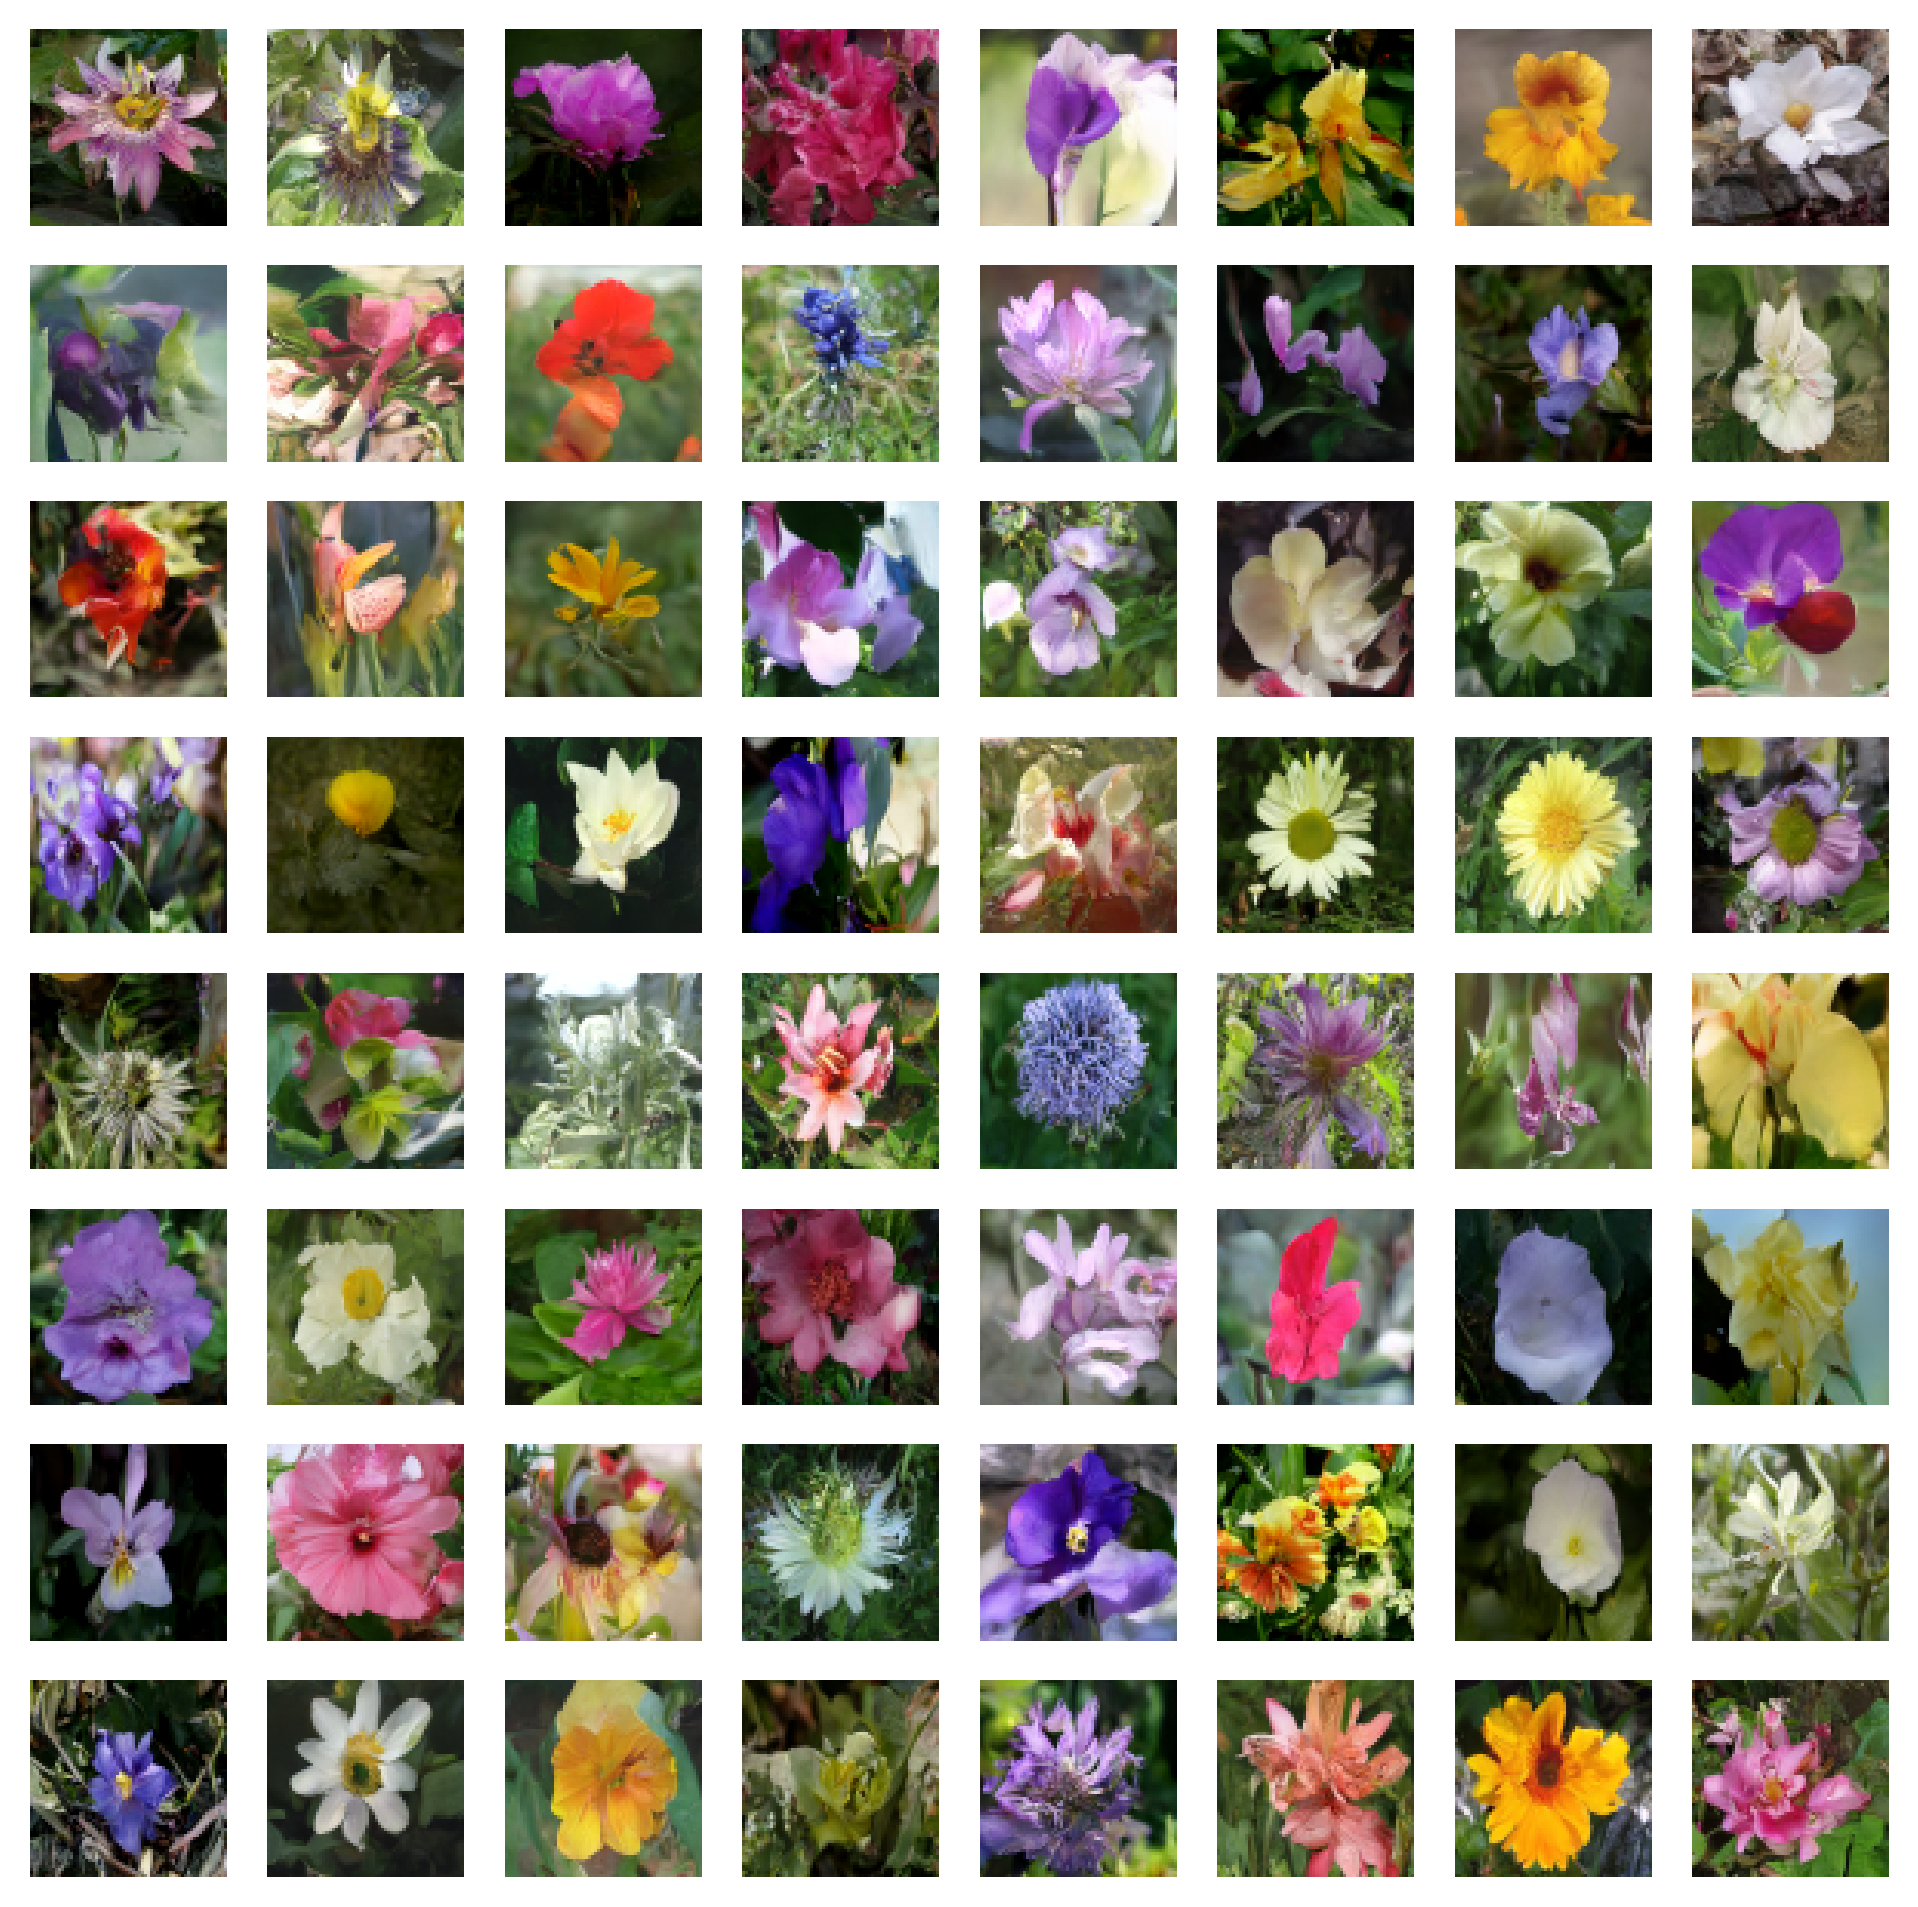

In [177]:
sampler = EulerAncestralSampler(trainer.model, trainer.state.ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=64, diffusion_steps=400, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=300)

100%|██████████| 200/200 [00:14<00:00, 14.26it/s]


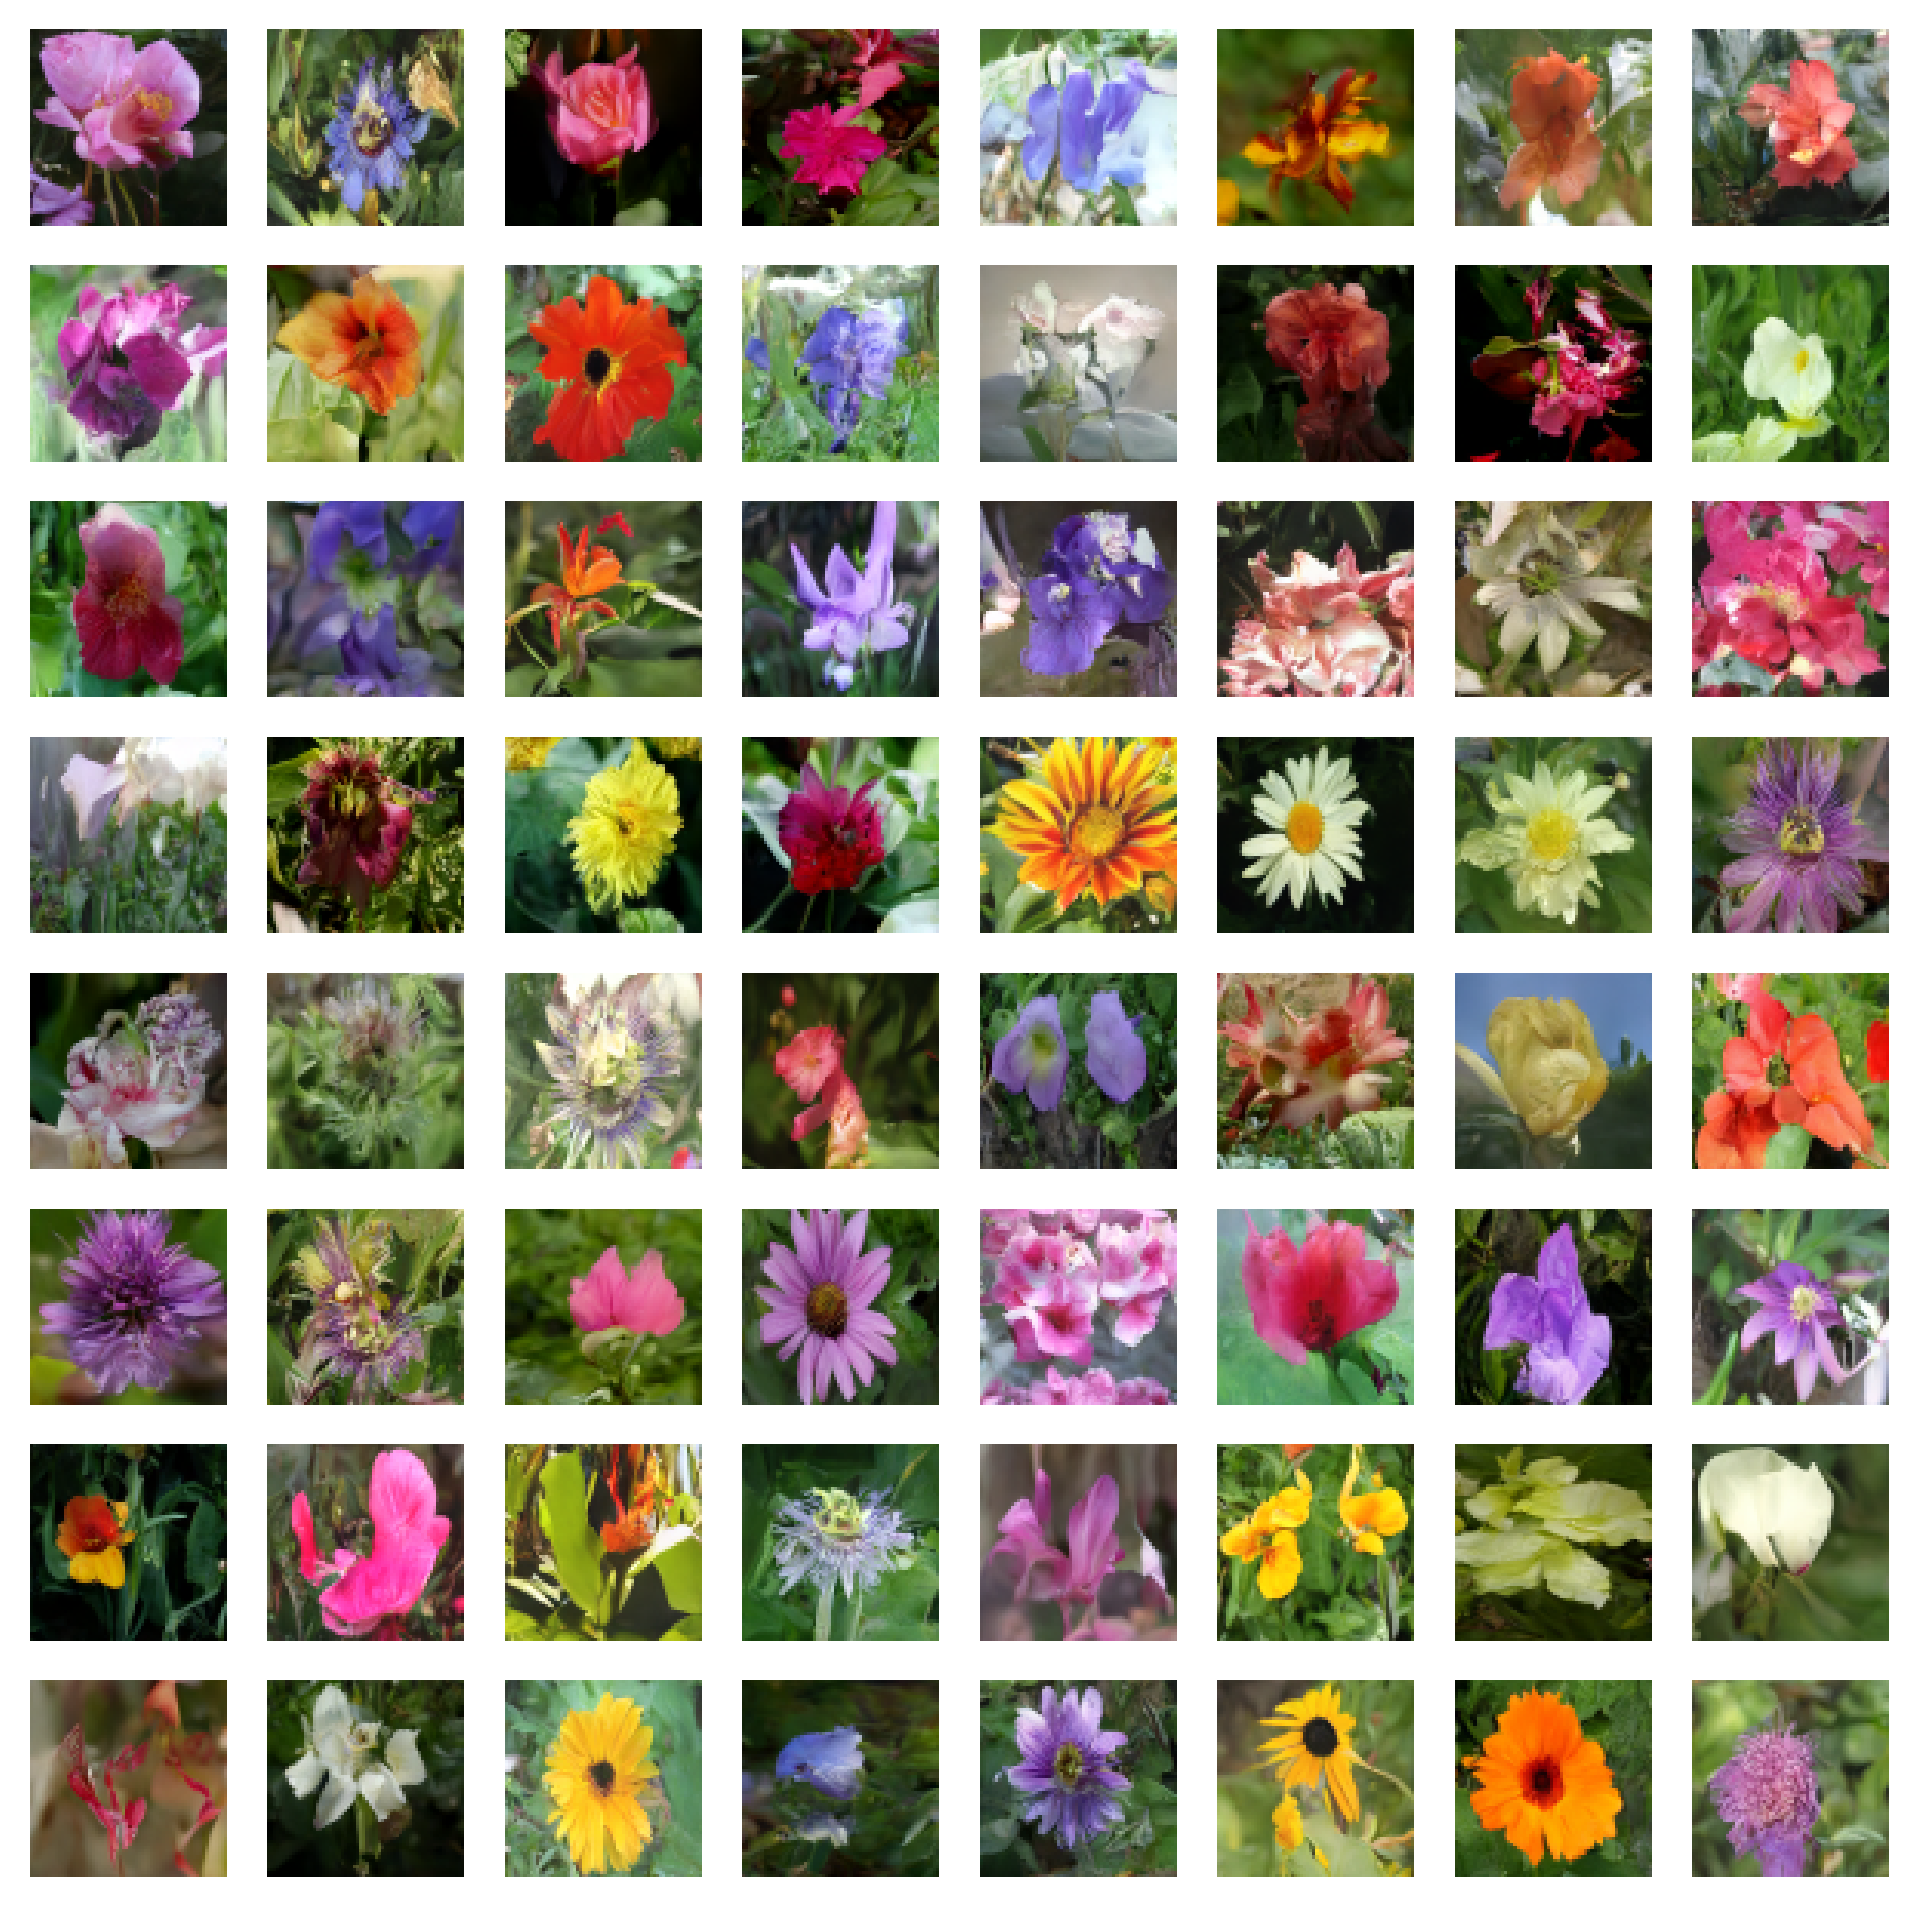

In [179]:
sampler = EulerAncestralSampler(trainer.model, trainer.state.ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=64, diffusion_steps=200, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=300)

100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


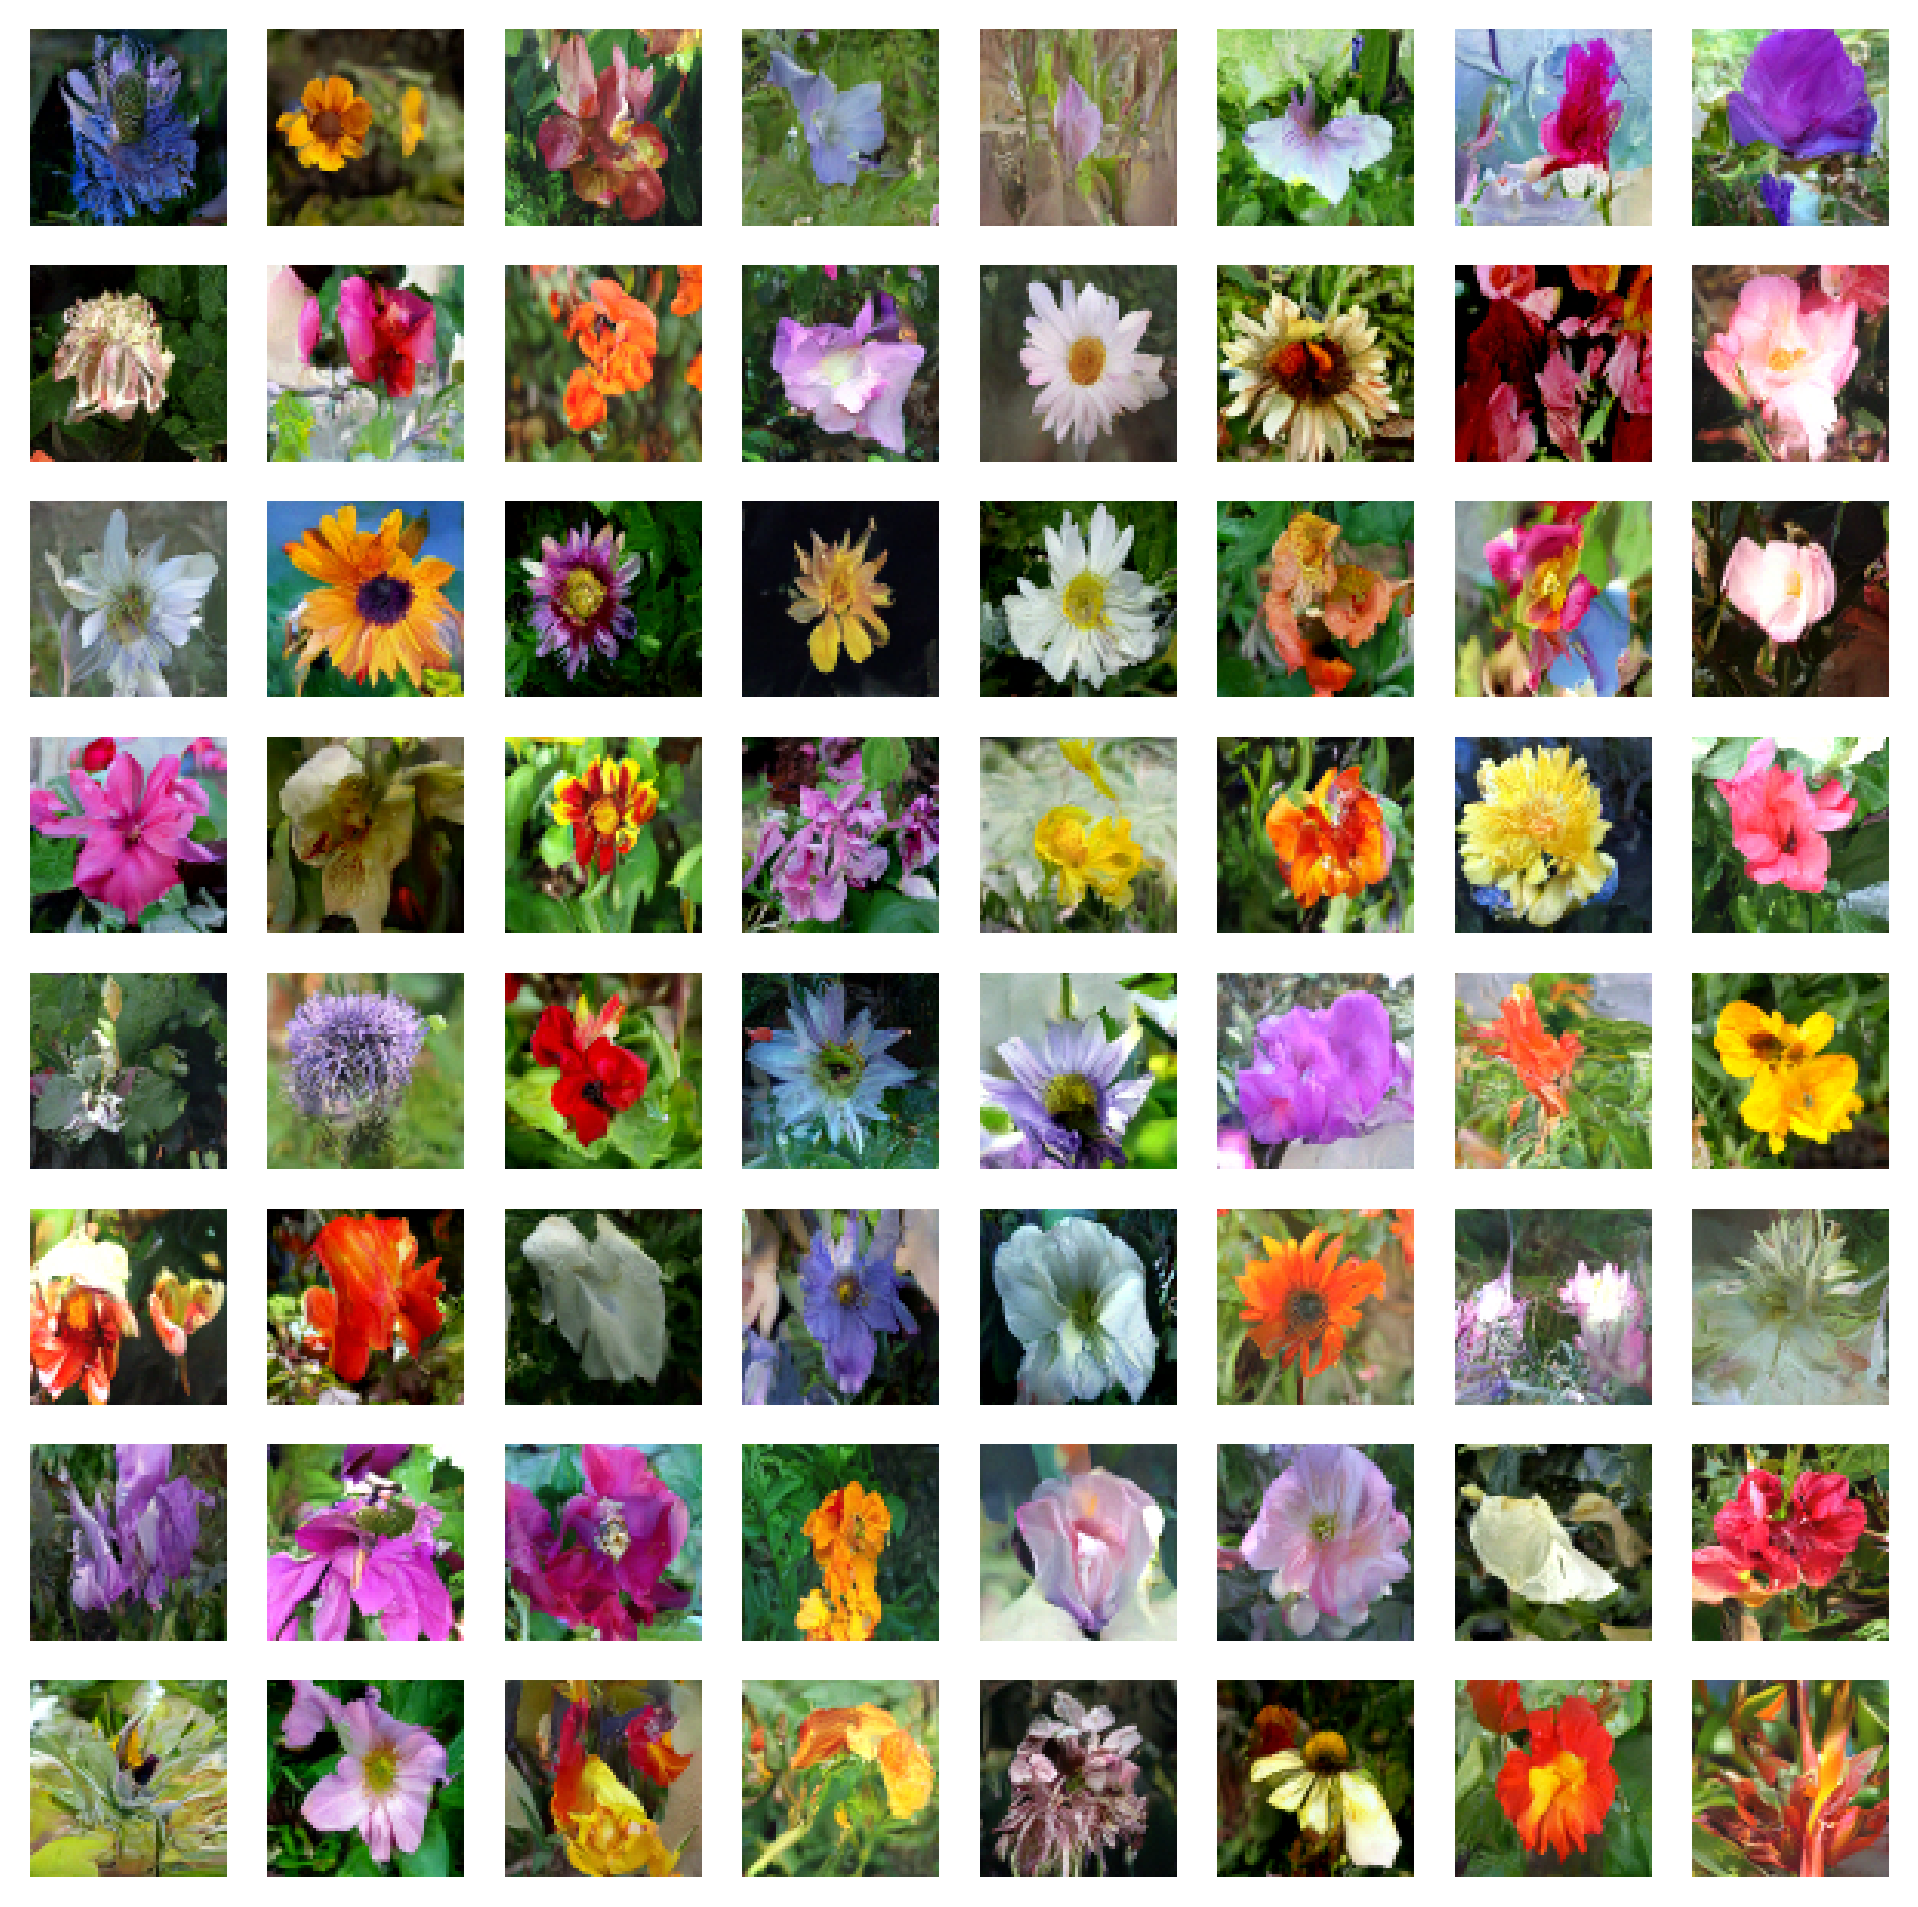

In [19]:
sampler = RK4Sampler(trainer.model, trainer.state.ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=64, diffusion_steps=6, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=300)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:21<00:00, 14.15it/s]


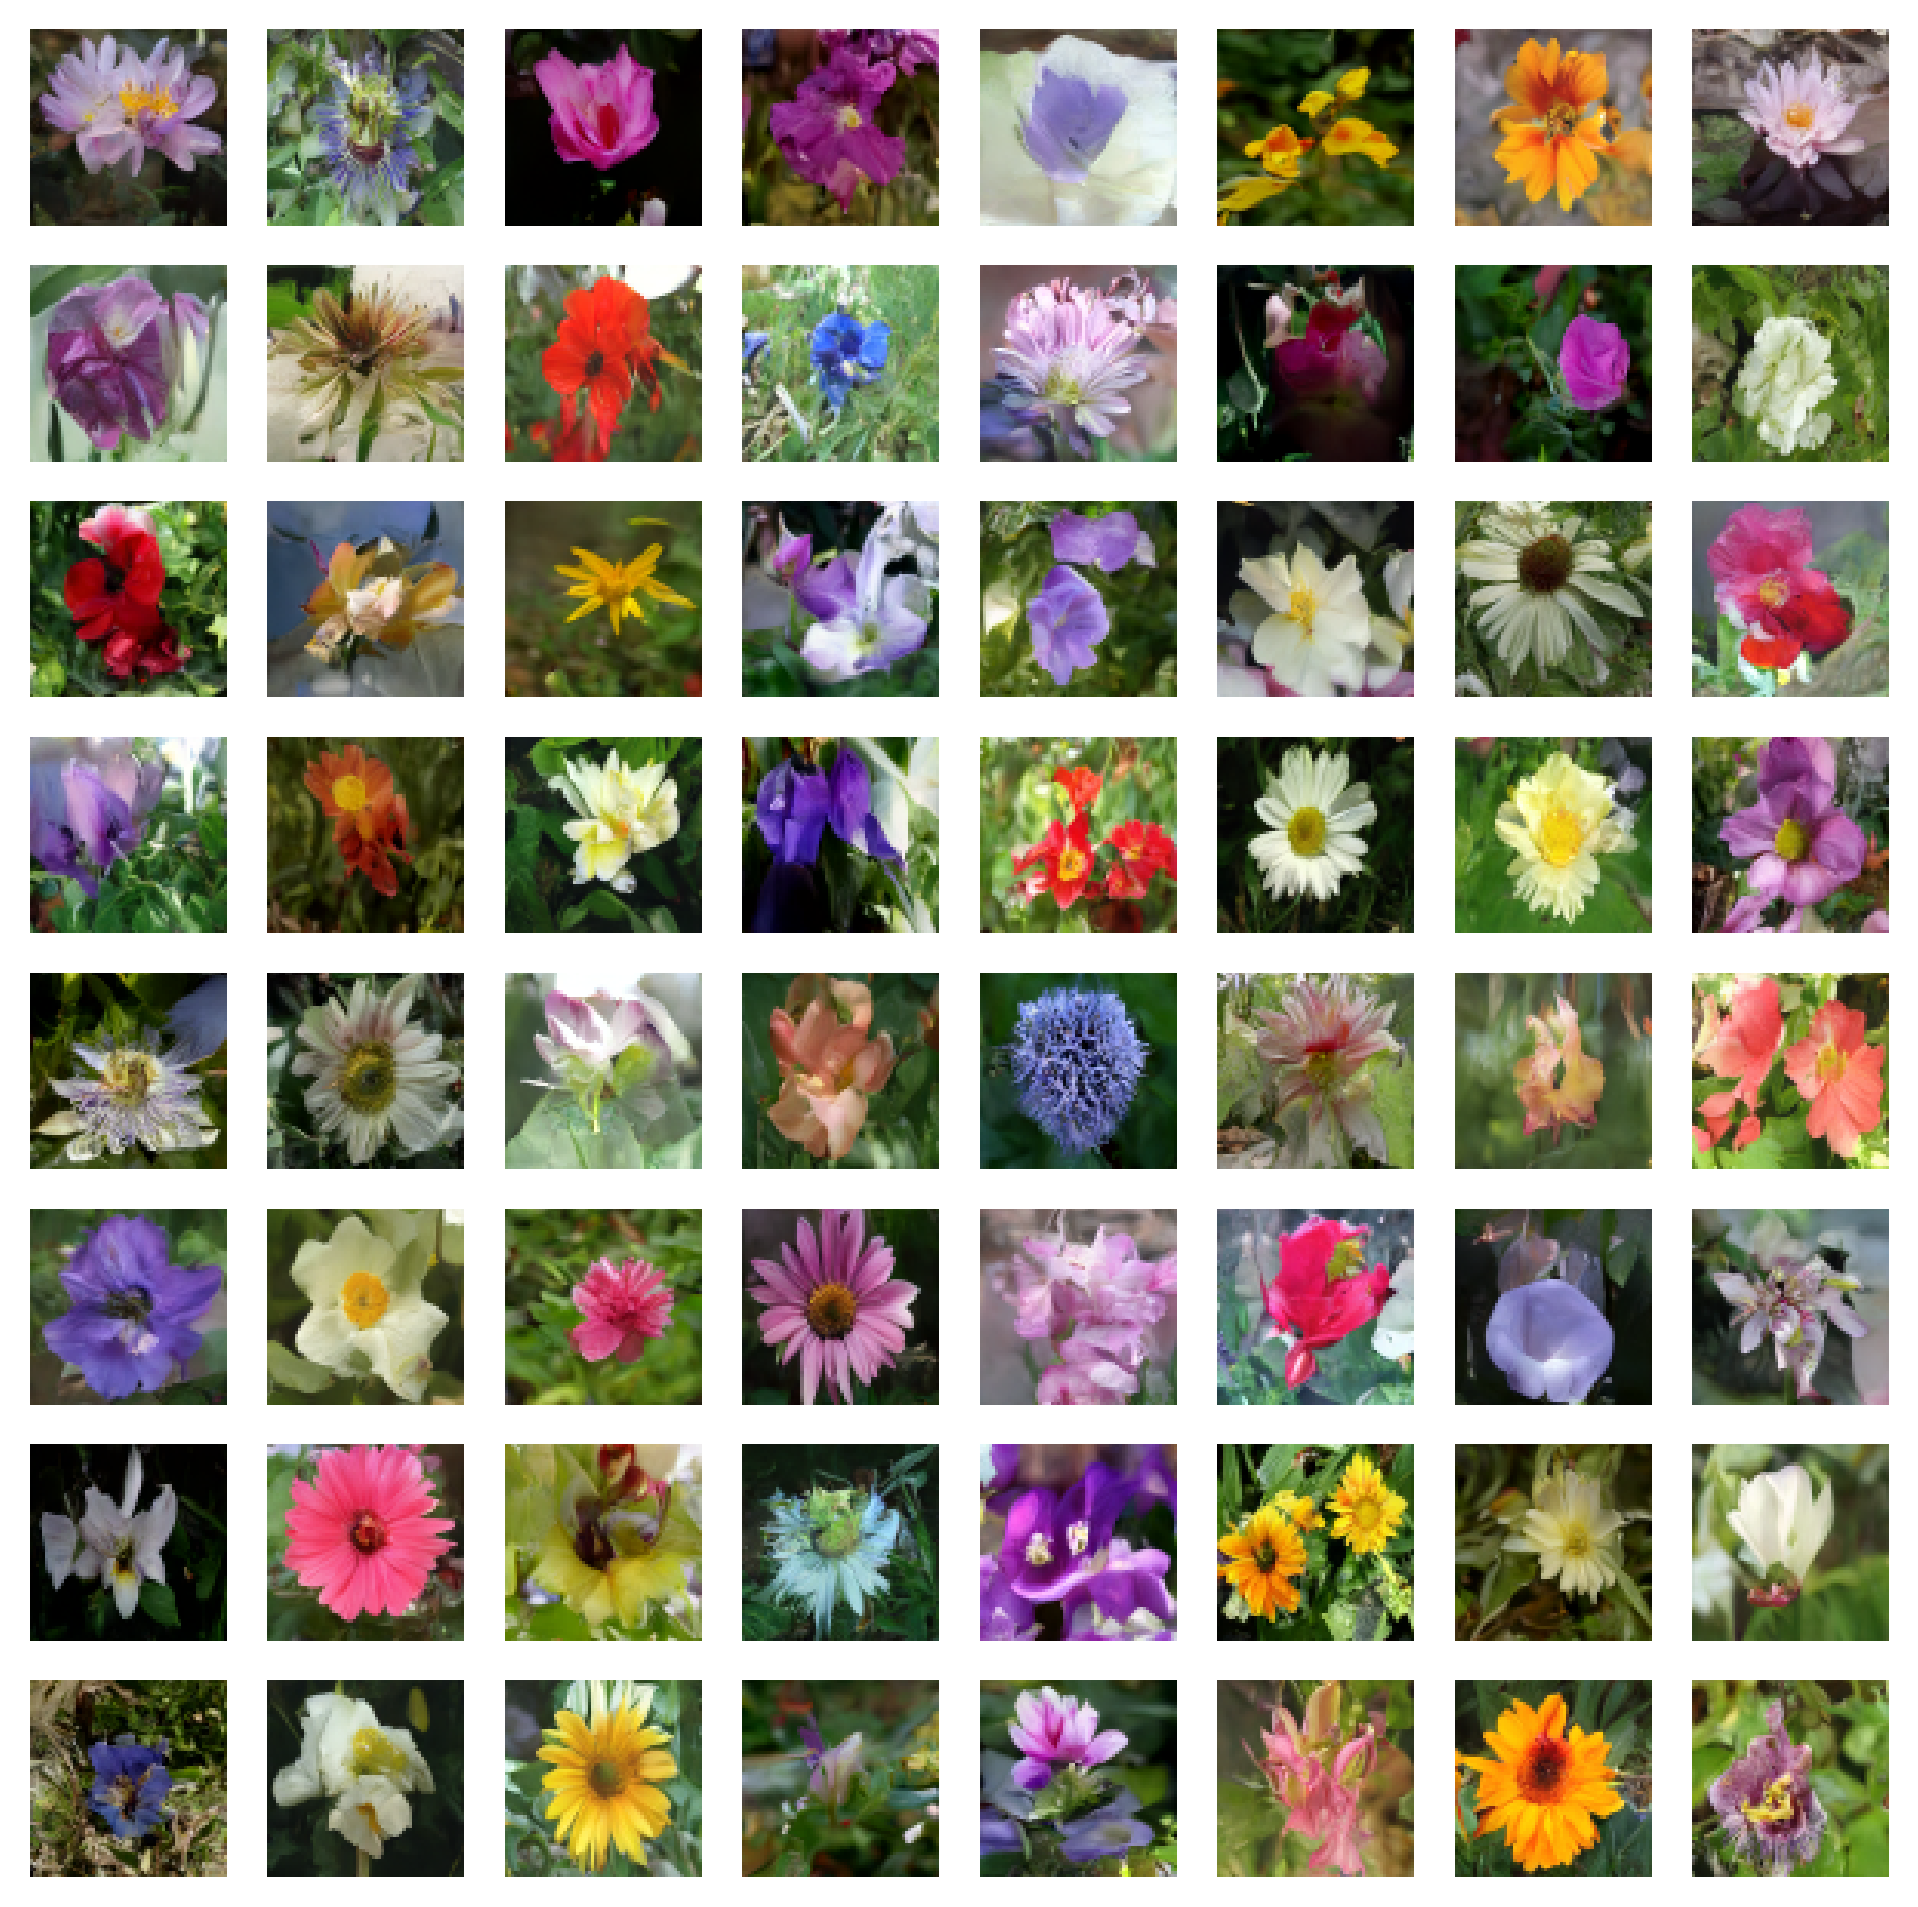

In [95]:
sampler = EulerAncestralSampler(trainer.model, trainer.state.ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=64, diffusion_steps=300, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=300)

100%|██████████| 1000/1000 [00:17<00:00, 56.54it/s]


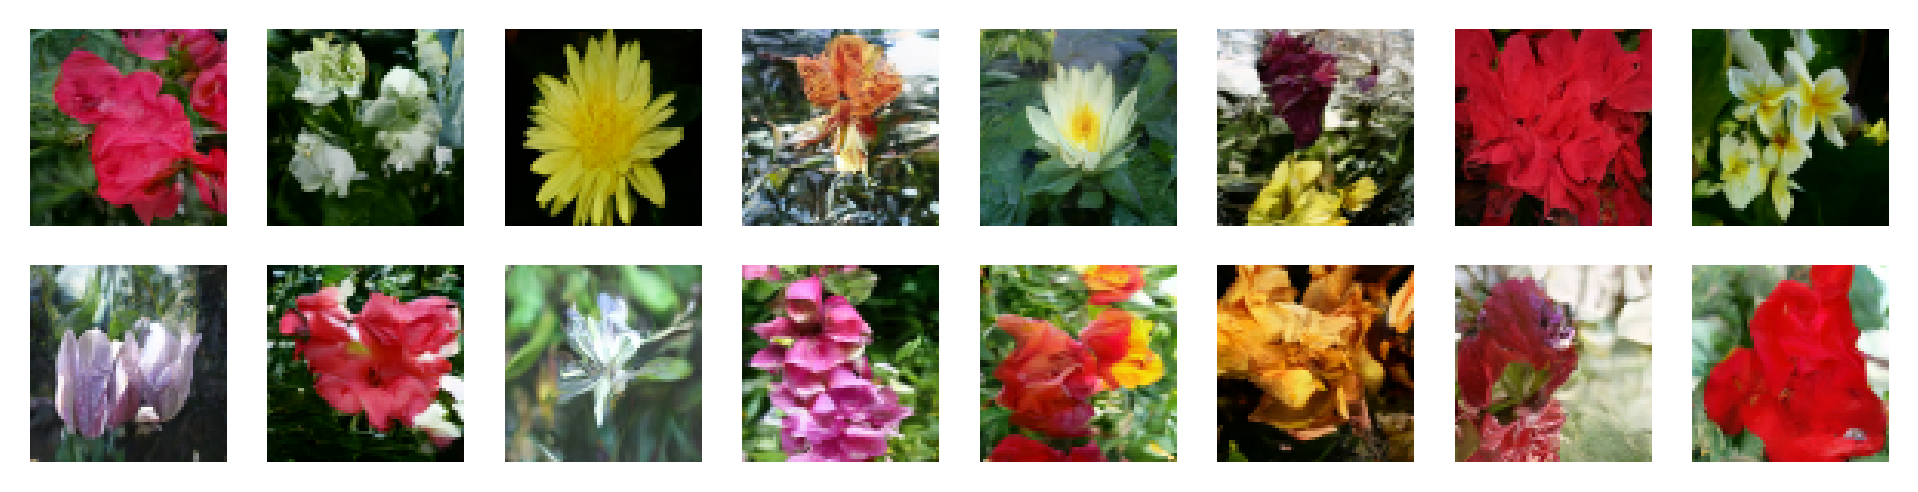

In [56]:
sampler = DDPMSampler(trainer.model, trainer.state.params, trainer.noise_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=16, start_step=1000, priors=None)
plotImages(samples, dpi=300)

  0%|          | 0/1000 [00:00<?, ?it/s]

[]


100%|██████████| 1000/1000 [00:15<00:00, 65.72it/s]


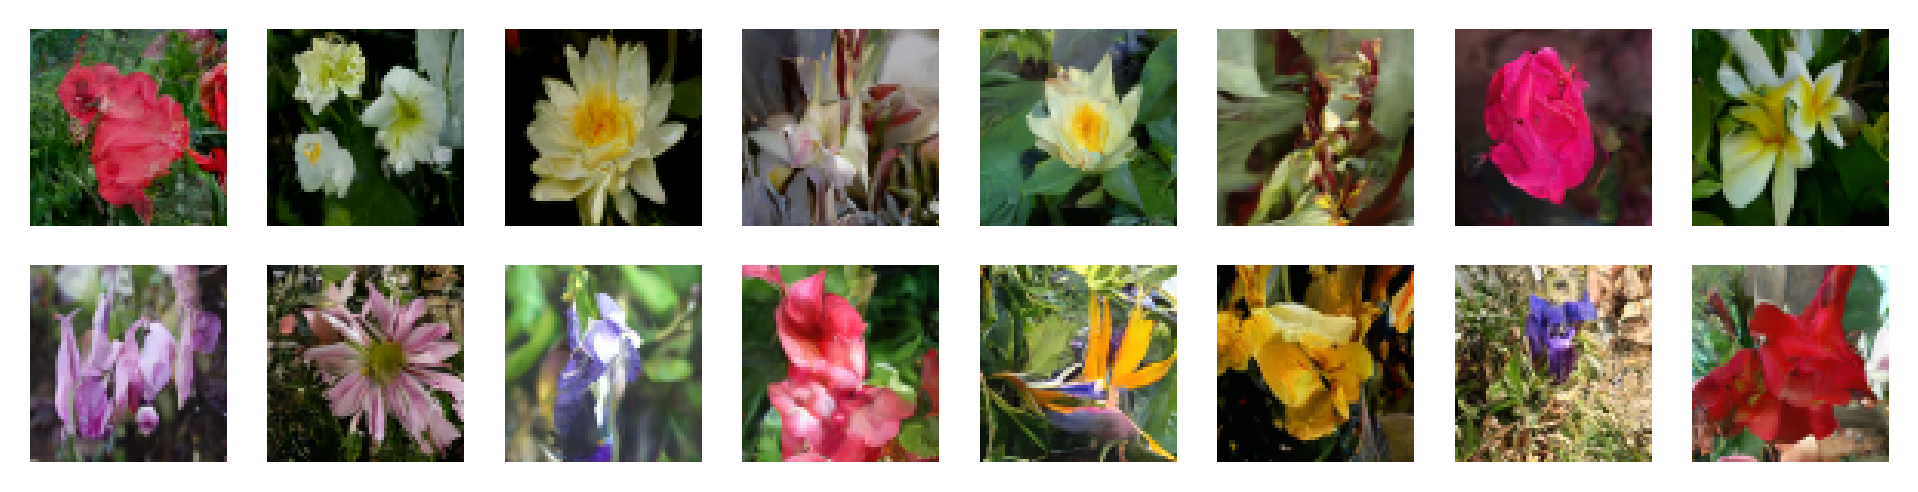

In [28]:
sampler = DDPMSampler(trainer.model, trainer.best_state.params, trainer.noise_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=16, start_step=1000, priors=None)
plotImages(samples, dpi=300)

  0%|          | 0/1000 [00:00<?, ?it/s]

[]


100%|██████████| 1000/1000 [00:56<00:00, 17.73it/s]


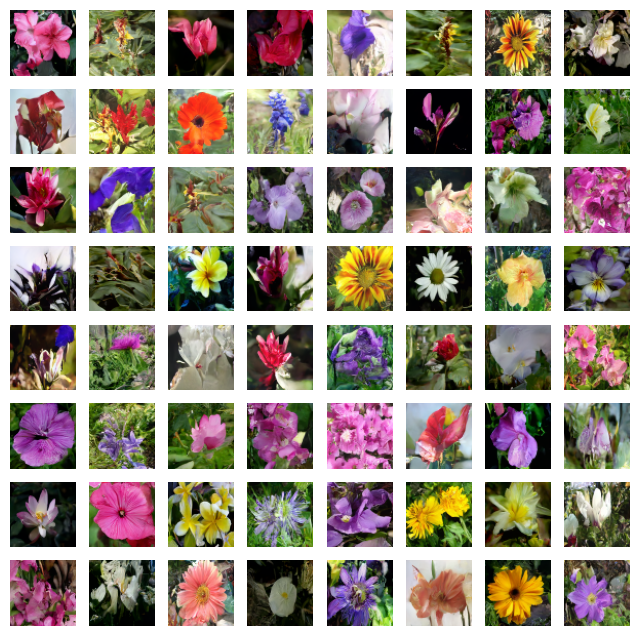

In [29]:
sampler = DDPMSampler(trainer.model, trainer.best_state.params, trainer.noise_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=64, start_step=1000, priors=None)
plotImages(samples)